Loading functions

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### voice data prep

In [2]:
data_voice_cut = load_file('voice500')

features = 2

data_size = len(data_voice_cut.index)

voice_X = data_voice_cut.iloc[:, :-1]
voice_y = data_voice_cut.iloc[:, -1]

# code categories to -1/1
gender_encoder = LabelEncoder()
voice_y = np.array(gender_encoder.fit_transform(voice_y))
voice_y = voice_y * 2 - 1

# normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(voice_X)
voice_X = np.array(scaler.transform(voice_X))
voice_X = voice_X[:,0:features]

In [3]:
def voice_prep(data, features, samples):
    data = data.sample(samples)
    data_size = len(data.index)

    voice_X = data.iloc[:, :-1]
    voice_y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    voice_y = np.array(gender_encoder.fit_transform(voice_y))
    voice_y = voice_y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(voice_X)
    voice_X = np.array(scaler.transform(voice_X))
    voice_X = voice_X[:,0:features]
    
    return voice_X, voice_y

In [4]:
voice_X, voice_y = voice_prep(pd.read_csv('voice.csv'), 2, 500)

In [61]:
data_x = voice_X
data_y = voice_y

model: [ 1.00998671e-10 -5.35028899e-01  4.79389851e-01 -1.15786625e-01
 -9.99998592e-01 -1.76163805e-01  1.54392149e-01  6.63694216e-01
  3.27818567e-01  1.00000000e+00]
0.0
correlation with the rademacher vector: 1.3753340786005204 0.0027506681572010408


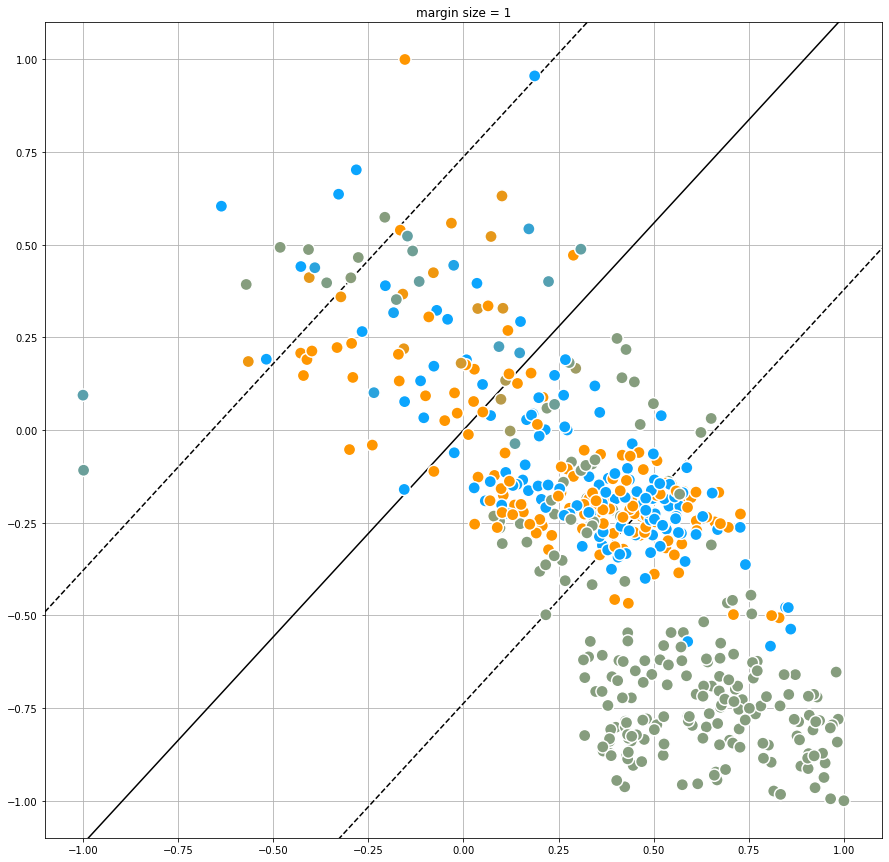

model: [ 1.00000000e-12 -2.29578840e-02  2.83595776e-03 -2.30784932e-02
 -1.67839050e-02 -3.08059645e-02  1.24472583e-02  1.63873194e-03
  6.64306003e-03]
correlation with the radvec: 25.00090389703231 0.050001807794064615


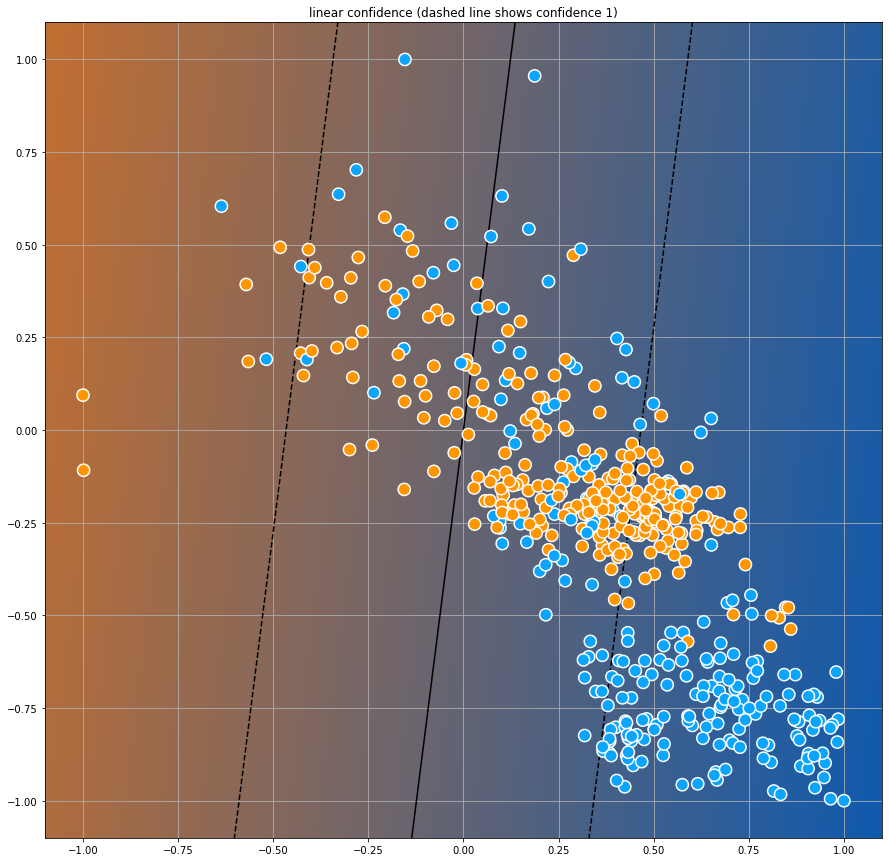

In [90]:
random = np.array([rd.randint(0, 1) * 2 - 1 for x in range(data_size)])

#process_dataset(
#   X=data_x, Y=seeds_y, radvec=random, model_type="svc",
#    margin=1, bounds=1e-12,
#    figsize=[15,15], dotsize=150, lim_padding=0.1, color_bar=False, verbose=True)


process_dataset(
    X=data_x, Y=data_y, radvec=random, model_type="margin_loss",

    #method='de', kwargs={'popsize':500},
    method='da', kwargs={'maxiter':100, 'initial_temp':5000, 'accept':-5},
    margin=1, bounds=1e-12,
    figsize=[15,15], dotsize=150, lim_padding=0.1, color_bar=False, verbose=True)


process_dataset(
    X=data_x, Y=data_y, radvec=random, model_type="confidence",
    margin=1, bounds=1e-12,
    figsize=[15,15], dotsize=150, lim_padding=0.1, color_bar=False, verbose=True)


# Calculating rademacher for different bounds / margins

In [28]:
BOUNDS = np.array([1e-12, 0.5, 1.0]) # np.array([, , ])

MARGINS = np.array([0, 0.5, 1.0, 2.0])

#MARGINS = np.array([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0,
#                    1.2, 1.4 , 1.6, 1.8, 2.0])
#MARGINS = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
#                    1.1, 1.2, 1.3 , 1.4 , 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

PUMP_X = voice_X
PUMP_Y = voice_y

runs_per_sample = 5

maxiter = 100
init_temp = 5500
accept = -5

pump_cycles = 1000

folder_name = "voice_8_500_maxiter100"


In [29]:
for pc in range(pump_cycles):
    # generate rademacher vector
    radvec = [rd.randint(0, 1) * 2 - 1 for x in range(PUMP_X.shape[0])]
    print('\n', pc, '///')
    
    for b in BOUNDS:
        ## Calculate Confidence Rademacher Complexity
        DATA_SAVE_NAME = 'histories/'+folder_name+'/confidence_b' + str(b)
        
        try:
            history = load_file(DATA_SAVE_NAME)
        except:
            print('creating new file')
            history = RDhistory('confidence')

        pump_rademacher(PUMP_X, PUMP_Y,
                        history=history,
                        radvec=radvec,
                        runs_per_sample=1,
                        margin=1.0, bounds=b,
                        verbose=False)

        save_file(DATA_SAVE_NAME, history)

        ## Calculate Margin loss Rademacher Complexity for all the margins
        for mar in MARGINS:
            # print(mar, end=' ')

            DATA_SAVE_NAME = 'histories/'+folder_name+'/margin_loss_b' + str(b) + '_m' + str(mar)

            try:
                history = load_file(DATA_SAVE_NAME)
            except:
                print('new file', end=' ')
                history = RDhistory('margin_loss')

            pump_rademacher(PUMP_X, PUMP_Y,
                            history=history,
                            radvec=radvec,
                            runs_per_sample=runs_per_sample,
                            margin=mar, bounds=b,
                            verbose=False,
                            method='da', kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})

            save_file(DATA_SAVE_NAME, history)
            
            
            


 0 ///
creating new file
b:  1e-12 	m:  1.0 	c:  15.286514542601605
new file b:  1e-12 	m:  0.0 	c:  33.0
new file b:  1e-12 	m:  0.5 	c:  20.993804781042712
new file b:  1e-12 	m:  1.0 	c:  18.881836078097745
new file b:  1e-12 	m:  2.0 	c:  15.786174993822991
creating new file
b:  0.5 	m:  1.0 	c:  211.53792239037512
new file b:  0.5 	m:  0.0 	c:  30.0
new file b:  0.5 	m:  0.5 	c:  21.09914103999834
new file b:  0.5 	m:  1.0 	c:  18.884785281049478
new file b:  0.5 	m:  2.0 	c:  16.073011764995712
creating new file
b:  1.0 	m:  1.0 	c:  407.7893302385413
new file b:  1.0 	m:  0.0 	c:  35.0
new file b:  1.0 	m:  0.5 	c:  21.09439807425919
new file b:  1.0 	m:  1.0 	c:  18.885776510813685
new file b:  1.0 	m:  2.0 	c:  16.073403878047323

 1 ///
b:  1e-12 	m:  1.0 	c:  46.9650929958473
b:  1e-12 	m:  0.0 	c:  57.0
b:  1e-12 	m:  0.5 	c:  46.08490665263672
b:  1e-12 	m:  1.0 	c:  37.26836636765967
b:  1e-12 	m:  2.0 	c:  30.65251026099691
b:  0.5 	m:  1.0 	c:  164.07334615107348
b:  0

b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  23.672923033581846
b:  1.0 	m:  1.0 	c:  15.797394251731001
b:  1.0 	m:  2.0 	c:  11.65271002386504

 14 ///
b:  1e-12 	m:  1.0 	c:  52.48872135850541
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  24.74977253988277
b:  1e-12 	m:  1.0 	c:  22.330200007431102
b:  1e-12 	m:  2.0 	c:  18.729070163735
b:  0.5 	m:  1.0 	c:  119.16971318713841
b:  0.5 	m:  0.0 	c:  36.0
b:  0.5 	m:  0.5 	c:  25.27307776514079
b:  0.5 	m:  1.0 	c:  23.382876292085836
b:  0.5 	m:  2.0 	c:  19.400193332312163
b:  1.0 	m:  1.0 	c:  185.85070501590474
b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  25.270754416514542
b:  1.0 	m:  1.0 	c:  24.184338506400053
b:  1.0 	m:  2.0 	c:  21.577363072004147

 15 ///
b:  1e-12 	m:  1.0 	c:  24.26393494984608
b:  1e-12 	m:  0.0 	c:  49.0
b:  1e-12 	m:  0.5 	c:  36.15197117478866
b:  1e-12 	m:  1.0 	c:  25.206573103466418
b:  1e-12 	m:  2.0 	c:  16.57035364787893
b:  0.5 	m:  1.0 	c:  106.69079622126057
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  23.753546038172907
b:  1.0 	m:  1.0 	c:  21.877094927854102
b:  1.0 	m:  2.0 	c:  16.401567484181577

 28 ///
b:  1e-12 	m:  1.0 	c:  42.82389813897775
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  3.444033021342083
b:  1e-12 	m:  1.0 	c:  1.062376538375056
b:  1e-12 	m:  2.0 	c:  -1.7236686047778864
b:  0.5 	m:  1.0 	c:  124.55396364230255
b:  0.5 	m:  0.0 	c:  20.0
b:  0.5 	m:  0.5 	c:  3.5284523834466883
b:  0.5 	m:  1.0 	c:  1.2157524606116397
b:  0.5 	m:  2.0 	c:  -1.4654641245455302
b:  1.0 	m:  1.0 	c:  206.28402914579084
b:  1.0 	m:  0.0 	c:  22.0
b:  1.0 	m:  0.5 	c:  3.5539942961392317
b:  1.0 	m:  1.0 	c:  1.21476857599004
b:  1.0 	m:  2.0 	c:  -1.4654328697300105

 29 ///
b:  1e-12 	m:  1.0 	c:  21.408007678246346
b:  1e-12 	m:  0.0 	c:  54.0
b:  1e-12 	m:  0.5 	c:  37.51309944928232
b:  1e-12 	m:  1.0 	c:  31.121525502758157
b:  1e-12 	m:  2.0 	c:  23.735348318335493
b:  0.5 	m:  1.0 	c:  68.11950064069086
b:  0.5 	m:

b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  28.52216720656729
b:  1.0 	m:  1.0 	c:  24.587485542525858
b:  1.0 	m:  2.0 	c:  22.558209504706745

 42 ///
b:  1e-12 	m:  1.0 	c:  26.401505782090222
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  20.24818567474768
b:  1e-12 	m:  1.0 	c:  16.360990355675874
b:  1e-12 	m:  2.0 	c:  8.888713564372203
b:  0.5 	m:  1.0 	c:  83.21644703521373
b:  0.5 	m:  0.0 	c:  33.0
b:  0.5 	m:  0.5 	c:  20.736851086582703
b:  0.5 	m:  1.0 	c:  16.462426114630958
b:  0.5 	m:  2.0 	c:  13.34320914674711
b:  1.0 	m:  1.0 	c:  140.03138828845087
b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  20.737061451462097
b:  1.0 	m:  1.0 	c:  16.006629954381765
b:  1.0 	m:  2.0 	c:  13.343214416581986

 43 ///
b:  1e-12 	m:  1.0 	c:  48.1908563567142
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  23.70200124174181
b:  1e-12 	m:  1.0 	c:  21.980000049600907
b:  1e-12 	m:  2.0 	c:  17.313110787322415
b:  0.5 	m:  1.0 	c:  79.31709302069397
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  12.677099855214925
b:  1.0 	m:  1.0 	c:  10.005301714105931
b:  1.0 	m:  2.0 	c:  7.067873106176936

 56 ///
b:  1e-12 	m:  1.0 	c:  40.90977508702352
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m:  0.5 	c:  33.67810320104586
b:  1e-12 	m:  1.0 	c:  31.023542597860857
b:  1e-12 	m:  2.0 	c:  27.482257867042396
b:  0.5 	m:  1.0 	c:  187.57398889088302
b:  0.5 	m:  0.0 	c:  42.0
b:  0.5 	m:  0.5 	c:  33.69682260158558
b:  0.5 	m:  1.0 	c:  31.03648861045802
b:  0.5 	m:  2.0 	c:  27.61189299134901
b:  1.0 	m:  1.0 	c:  334.23820269503597
b:  1.0 	m:  0.0 	c:  46.0
b:  1.0 	m:  0.5 	c:  33.70217648513514
b:  1.0 	m:  1.0 	c:  31.03626313034574
b:  1.0 	m:  2.0 	c:  27.606225074515024

 57 ///
b:  1e-12 	m:  1.0 	c:  16.301000962260694
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  27.800247322117176
b:  1e-12 	m:  1.0 	c:  21.187813854752175
b:  1e-12 	m:  2.0 	c:  19.461017604760137
b:  0.5 	m:  1.0 	c:  108.31989007751592
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  15.0
b:  1.0 	m:  0.5 	c:  3.2132405606079164
b:  1.0 	m:  1.0 	c:  0.7753262625871495
b:  1.0 	m:  2.0 	c:  0.3876371377936625

 70 ///
b:  1e-12 	m:  1.0 	c:  12.17002049582237
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  18.102737640326506
b:  1e-12 	m:  1.0 	c:  11.043205700124687
b:  1e-12 	m:  2.0 	c:  7.494723194756087
b:  0.5 	m:  1.0 	c:  53.2545856511573
b:  0.5 	m:  0.0 	c:  30.0
b:  0.5 	m:  0.5 	c:  18.79373022401316
b:  0.5 	m:  1.0 	c:  11.048753521784915
b:  0.5 	m:  2.0 	c:  8.217900271967457
b:  1.0 	m:  1.0 	c:  94.33915080657437
b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  18.793871622698056
b:  1.0 	m:  1.0 	c:  11.051848178627283
b:  1.0 	m:  2.0 	c:  8.217936527744463

 71 ///
b:  1e-12 	m:  1.0 	c:  30.783638739086076
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  12.318860778118312
b:  1e-12 	m:  1.0 	c:  -0.6272769054694667
b:  1e-12 	m:  2.0 	c:  -7.101653448195332
b:  0.5 	m:  1.0 	c:  176.9651879111817
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  14.0
b:  1.0 	m:  0.5 	c:  3.9379944412857144
b:  1.0 	m:  1.0 	c:  -4.33101194861219
b:  1.0 	m:  2.0 	c:  -9.605715640529707

 84 ///
b:  1e-12 	m:  1.0 	c:  62.03013570391368
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -3.4209651195631414
b:  1e-12 	m:  1.0 	c:  -18.29329809791671
b:  1e-12 	m:  2.0 	c:  -26.103046510312204
b:  0.5 	m:  1.0 	c:  247.42389423022578
b:  0.5 	m:  0.0 	c:  12.0
b:  0.5 	m:  0.5 	c:  1.4753985174925859
b:  0.5 	m:  1.0 	c:  -13.813531955602825
b:  0.5 	m:  2.0 	c:  -13.957433121423083
b:  1.0 	m:  1.0 	c:  432.8176527569086
b:  1.0 	m:  0.0 	c:  12.0
b:  1.0 	m:  0.5 	c:  1.4753393406459558
b:  1.0 	m:  1.0 	c:  -13.89038086948505
b:  1.0 	m:  2.0 	c:  -13.977457718295362

 85 ///
b:  1e-12 	m:  1.0 	c:  33.54439931226046
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  30.559673612807913
b:  1e-12 	m:  1.0 	c:  27.05211966234026
b:  1e-12 	m:  2.0 	c:  24.089272290857295
b:  0.5 	m:  1.0 	c:  197.50619659603308
b:  0.5 

b:  1.0 	m:  0.0 	c:  71.0
b:  1.0 	m:  0.5 	c:  66.35530729510155
b:  1.0 	m:  1.0 	c:  65.15132844776431
b:  1.0 	m:  2.0 	c:  64.46648305799644

 98 ///
b:  1e-12 	m:  1.0 	c:  15.099436009527237
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m:  0.5 	c:  23.84586851597
b:  1e-12 	m:  1.0 	c:  19.25917681951917
b:  1e-12 	m:  2.0 	c:  13.03169585440456
b:  0.5 	m:  1.0 	c:  48.2132556042267
b:  0.5 	m:  0.0 	c:  36.0
b:  0.5 	m:  0.5 	c:  24.257562432832177
b:  0.5 	m:  1.0 	c:  21.138221139686436
b:  0.5 	m:  2.0 	c:  19.593927159250818
b:  1.0 	m:  1.0 	c:  81.32707519899247
b:  1.0 	m:  0.0 	c:  36.0
b:  1.0 	m:  0.5 	c:  24.256628306021053
b:  1.0 	m:  1.0 	c:  21.1390318260358
b:  1.0 	m:  2.0 	c:  19.592150029936498

 99 ///
b:  1e-12 	m:  1.0 	c:  22.70588108362819
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  17.442535190836352
b:  1e-12 	m:  1.0 	c:  13.891253066633123
b:  1e-12 	m:  2.0 	c:  9.497299742501948
b:  0.5 	m:  1.0 	c:  88.76806094271707
b:  0.5 	m:  0.0 	c:  31

b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  20.78821097598209
b:  1.0 	m:  1.0 	c:  20.004276732278658
b:  1.0 	m:  2.0 	c:  18.28851702630077

 112 ///
b:  1e-12 	m:  1.0 	c:  33.97093560803481
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  22.459795293633846
b:  1e-12 	m:  1.0 	c:  16.78588876299078
b:  1e-12 	m:  2.0 	c:  12.540916204871504
b:  0.5 	m:  1.0 	c:  92.84479245670784
b:  0.5 	m:  0.0 	c:  34.0
b:  0.5 	m:  0.5 	c:  25.040106185260864
b:  0.5 	m:  1.0 	c:  21.545716487507526
b:  0.5 	m:  2.0 	c:  17.762826724211784
b:  1.0 	m:  1.0 	c:  151.7186493054987
b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  25.356746892077684
b:  1.0 	m:  1.0 	c:  21.556805573424704
b:  1.0 	m:  2.0 	c:  17.762826723894477

 113 ///
b:  1e-12 	m:  1.0 	c:  20.986017166432944
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  5.5943596573065
b:  1e-12 	m:  1.0 	c:  -0.42909995796941036
b:  1e-12 	m:  2.0 	c:  -7.210487860804838
b:  0.5 	m:  1.0 	c:  211.58912057295476
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  50.0
b:  1.0 	m:  0.5 	c:  40.78477779189538
b:  1.0 	m:  1.0 	c:  37.85925674762108
b:  1.0 	m:  2.0 	c:  35.65505723114638

 126 ///
b:  1e-12 	m:  1.0 	c:  56.92599409467368
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  5.163056571180167
b:  1e-12 	m:  1.0 	c:  -0.9978286997927714
b:  1e-12 	m:  2.0 	c:  -4.050717061576487
b:  0.5 	m:  1.0 	c:  135.97599702513713
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  5.818334662164656
b:  0.5 	m:  1.0 	c:  0.4458765480504354
b:  0.5 	m:  2.0 	c:  -0.6503037755876591
b:  1.0 	m:  1.0 	c:  215.02599995575872
b:  1.0 	m:  0.0 	c:  25.0
b:  1.0 	m:  0.5 	c:  5.817521624693324
b:  1.0 	m:  1.0 	c:  0.6994868854659186
b:  1.0 	m:  2.0 	c:  -0.6503152860832389

 127 ///
b:  1e-12 	m:  1.0 	c:  31.971188167095455
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  5.930381872962009
b:  1e-12 	m:  1.0 	c:  0.057439715608357034
b:  1e-12 	m:  2.0 	c:  -6.472047189044962
b:  0.5 	m:  1.0 	c:  157.0838358146446
b:  0.5 	

b:  1.0 	m:  0.0 	c:  20.0
b:  1.0 	m:  0.5 	c:  4.139877822624822
b:  1.0 	m:  1.0 	c:  -0.18078324307508353
b:  1.0 	m:  2.0 	c:  -3.8748661566783333

 140 ///
b:  1e-12 	m:  1.0 	c:  34.28562443022103
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  27.244653837512857
b:  1e-12 	m:  1.0 	c:  23.611807056272248
b:  1e-12 	m:  2.0 	c:  21.418190563612434
b:  0.5 	m:  1.0 	c:  165.53596840992515
b:  0.5 	m:  0.0 	c:  42.0
b:  0.5 	m:  0.5 	c:  27.43743729270826
b:  0.5 	m:  1.0 	c:  24.669717883697633
b:  0.5 	m:  2.0 	c:  22.89394488878728
b:  1.0 	m:  1.0 	c:  296.7863123898917
b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  27.426593669155245
b:  1.0 	m:  1.0 	c:  24.690585416720168
b:  1.0 	m:  2.0 	c:  22.907656270919368

 141 ///
b:  1e-12 	m:  1.0 	c:  26.011506544281538
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  14.86088913179795
b:  1e-12 	m:  1.0 	c:  7.963896075354571
b:  1e-12 	m:  2.0 	c:  2.4915015257057984
b:  0.5 	m:  1.0 	c:  83.67829325846427
b:  0.5 	m

b:  1.0 	m:  0.0 	c:  36.0
b:  1.0 	m:  0.5 	c:  24.939412106137596
b:  1.0 	m:  1.0 	c:  22.28288662855038
b:  1.0 	m:  2.0 	c:  19.55326368807359

 154 ///
b:  1e-12 	m:  1.0 	c:  21.704469673964056
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  15.7745057839113
b:  1e-12 	m:  1.0 	c:  9.738850751916729
b:  1e-12 	m:  2.0 	c:  1.350451009094293
b:  0.5 	m:  1.0 	c:  136.88811790750964
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  16.876941396558493
b:  0.5 	m:  1.0 	c:  11.596262855914622
b:  0.5 	m:  2.0 	c:  8.78988441927306
b:  1.0 	m:  1.0 	c:  252.07176614128554
b:  1.0 	m:  0.0 	c:  33.0
b:  1.0 	m:  0.5 	c:  16.66642243393966
b:  1.0 	m:  1.0 	c:  11.594892233637228
b:  1.0 	m:  2.0 	c:  8.789870230103551

 155 ///
b:  1e-12 	m:  1.0 	c:  21.114863356315645
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  13.574171778770864
b:  1e-12 	m:  1.0 	c:  11.151589553532503
b:  1e-12 	m:  2.0 	c:  7.042877404092687
b:  0.5 	m:  1.0 	c:  21.114863356315645
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  20.806053633638665
b:  1.0 	m:  1.0 	c:  19.359175787270804
b:  1.0 	m:  2.0 	c:  18.967504710109626

 168 ///
b:  1e-12 	m:  1.0 	c:  46.96607838151692
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  10.026817879885037
b:  1e-12 	m:  1.0 	c:  7.403941489022092
b:  1e-12 	m:  2.0 	c:  -2.5424658011284267
b:  0.5 	m:  1.0 	c:  185.3638374454997
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  10.186841497053148
b:  0.5 	m:  1.0 	c:  7.444941439806957
b:  0.5 	m:  2.0 	c:  3.1392878719210433
b:  1.0 	m:  1.0 	c:  323.76159650975933
b:  1.0 	m:  0.0 	c:  24.0
b:  1.0 	m:  0.5 	c:  10.186523502337156
b:  1.0 	m:  1.0 	c:  7.444597306969518
b:  1.0 	m:  2.0 	c:  3.06450809252833

 169 ///
b:  1e-12 	m:  1.0 	c:  65.2843783731774
b:  1e-12 	m:  0.0 	c:  46.0
b:  1e-12 	m:  0.5 	c:  38.24833920754547
b:  1e-12 	m:  1.0 	c:  33.94770786564894
b:  1e-12 	m:  2.0 	c:  31.92248028614099
b:  0.5 	m:  1.0 	c:  180.1663790432309
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  16.0
b:  1.0 	m:  0.5 	c:  -5.5570587126847535
b:  1.0 	m:  1.0 	c:  -6.855323159587769
b:  1.0 	m:  2.0 	c:  -8.62143207093862

 182 ///
b:  1e-12 	m:  1.0 	c:  65.04151374625178
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  18.167528763386592
b:  1e-12 	m:  1.0 	c:  12.43761211779389
b:  1e-12 	m:  2.0 	c:  9.353624835442146
b:  0.5 	m:  1.0 	c:  118.85329945673564
b:  0.5 	m:  0.0 	c:  34.0
b:  0.5 	m:  0.5 	c:  19.15068496235984
b:  0.5 	m:  1.0 	c:  12.514904462183083
b:  0.5 	m:  2.0 	c:  9.997743608710358
b:  1.0 	m:  1.0 	c:  172.66508516732713
b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  19.151565115454154
b:  1.0 	m:  1.0 	c:  12.517613811014046
b:  1.0 	m:  2.0 	c:  9.996467422961853

 183 ///
b:  1e-12 	m:  1.0 	c:  72.72222410312988
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  5.754344415406985
b:  1e-12 	m:  1.0 	c:  0.1322235743379263
b:  1e-12 	m:  2.0 	c:  -5.973761037456288
b:  0.5 	m:  1.0 	c:  162.1034288196565
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  22.0
b:  1.0 	m:  0.5 	c:  7.174866992769131
b:  1.0 	m:  1.0 	c:  1.3712507809699126
b:  1.0 	m:  2.0 	c:  -3.1857437367497834

 196 ///
b:  1e-12 	m:  1.0 	c:  53.42316766114727
b:  1e-12 	m:  0.0 	c:  49.0
b:  1e-12 	m:  0.5 	c:  31.610517563985525
b:  1e-12 	m:  1.0 	c:  28.588441719490767
b:  1e-12 	m:  2.0 	c:  25.046618328452485
b:  0.5 	m:  1.0 	c:  147.01552129546457
b:  0.5 	m:  0.0 	c:  49.0
b:  0.5 	m:  0.5 	c:  33.21464812304944
b:  0.5 	m:  1.0 	c:  28.61915503339545
b:  0.5 	m:  2.0 	c:  25.840928802893544
b:  1.0 	m:  1.0 	c:  240.60787492996909
b:  1.0 	m:  0.0 	c:  53.0
b:  1.0 	m:  0.5 	c:  33.0609283034578
b:  1.0 	m:  1.0 	c:  29.470218772411123
b:  1.0 	m:  2.0 	c:  25.847489789787463

 197 ///
b:  1e-12 	m:  1.0 	c:  13.033460014214894
b:  1e-12 	m:  0.0 	c:  36.0
b:  1e-12 	m:  0.5 	c:  19.86215025862417
b:  1e-12 	m:  1.0 	c:  15.082856237007118
b:  1e-12 	m:  2.0 	c:  8.377048721716085
b:  0.5 	m:  1.0 	c:  281.57304937267884
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  12.0
b:  1.0 	m:  0.5 	c:  0.5404942554843695
b:  1.0 	m:  1.0 	c:  -2.957431430253876
b:  1.0 	m:  2.0 	c:  -3.501008603513119

 210 ///
b:  1e-12 	m:  1.0 	c:  59.80782435693857
b:  1e-12 	m:  0.0 	c:  74.0
b:  1e-12 	m:  0.5 	c:  53.2674519120418
b:  1e-12 	m:  1.0 	c:  48.116696892348806
b:  1e-12 	m:  2.0 	c:  41.274323846615985
b:  0.5 	m:  1.0 	c:  193.56958690283977
b:  0.5 	m:  0.0 	c:  67.0
b:  0.5 	m:  0.5 	c:  53.26739989520648
b:  0.5 	m:  1.0 	c:  49.227924393218075
b:  0.5 	m:  2.0 	c:  47.624328265223106
b:  1.0 	m:  1.0 	c:  327.33134944900854
b:  1.0 	m:  0.0 	c:  66.0
b:  1.0 	m:  0.5 	c:  53.265856504730465
b:  1.0 	m:  1.0 	c:  49.248463741746306
b:  1.0 	m:  2.0 	c:  46.82041383039346

 211 ///
b:  1e-12 	m:  1.0 	c:  71.23710709366398
b:  1e-12 	m:  0.0 	c:  55.0
b:  1e-12 	m:  0.5 	c:  51.557508030437425
b:  1e-12 	m:  1.0 	c:  45.68714362290132
b:  1e-12 	m:  2.0 	c:  41.85135820969862
b:  0.5 	m:  1.0 	c:  204.59457187007303
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  52.0
b:  1.0 	m:  0.5 	c:  38.59899767667246
b:  1.0 	m:  1.0 	c:  32.601392002483756
b:  1.0 	m:  2.0 	c:  29.476696714185245

 224 ///
b:  1e-12 	m:  1.0 	c:  64.95017206577663
b:  1e-12 	m:  0.0 	c:  46.0
b:  1e-12 	m:  0.5 	c:  38.6809756932883
b:  1e-12 	m:  1.0 	c:  35.95550222544164
b:  1e-12 	m:  2.0 	c:  32.09588056879631
b:  0.5 	m:  1.0 	c:  165.0268892363535
b:  0.5 	m:  0.0 	c:  48.0
b:  0.5 	m:  0.5 	c:  40.103795161370236
b:  0.5 	m:  1.0 	c:  36.50224866166437
b:  0.5 	m:  2.0 	c:  33.265420074302
b:  1.0 	m:  1.0 	c:  265.10360640713054
b:  1.0 	m:  0.0 	c:  47.0
b:  1.0 	m:  0.5 	c:  41.07341380349322
b:  1.0 	m:  1.0 	c:  36.063454189809114
b:  1.0 	m:  2.0 	c:  33.231669281362926

 225 ///
b:  1e-12 	m:  1.0 	c:  46.04062577603336
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  24.06206130958011
b:  1e-12 	m:  1.0 	c:  20.93973798806642
b:  1e-12 	m:  2.0 	c:  17.397116123687073
b:  0.5 	m:  1.0 	c:  111.20046992315952
b:  0.5 	m:  0.0 	c:

b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  25.624394779024737
b:  1.0 	m:  1.0 	c:  16.505651463771567
b:  1.0 	m:  2.0 	c:  14.069288722678243

 238 ///
b:  1e-12 	m:  1.0 	c:  36.96488949529986
b:  1e-12 	m:  0.0 	c:  66.0
b:  1e-12 	m:  0.5 	c:  44.06795227582975
b:  1e-12 	m:  1.0 	c:  39.03316921605602
b:  1e-12 	m:  2.0 	c:  36.517656923509605
b:  0.5 	m:  1.0 	c:  266.91282430975514
b:  0.5 	m:  0.0 	c:  58.0
b:  0.5 	m:  0.5 	c:  46.54259714174545
b:  0.5 	m:  1.0 	c:  41.23066803463661
b:  0.5 	m:  2.0 	c:  38.22047238054868
b:  1.0 	m:  1.0 	c:  496.86075912467015
b:  1.0 	m:  0.0 	c:  54.0
b:  1.0 	m:  0.5 	c:  46.543377277960225
b:  1.0 	m:  1.0 	c:  41.23191954700459
b:  1.0 	m:  2.0 	c:  38.22058468362742

 239 ///
b:  1e-12 	m:  1.0 	c:  43.20418317967861
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  19.712675640779054
b:  1e-12 	m:  1.0 	c:  11.727192354981645
b:  1e-12 	m:  2.0 	c:  5.122867705569387
b:  0.5 	m:  1.0 	c:  112.6419037709271
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  23.102080923974324
b:  1.0 	m:  1.0 	c:  18.626823601325604
b:  1.0 	m:  2.0 	c:  13.43516290429965

 252 ///
b:  1e-12 	m:  1.0 	c:  44.15307767689674
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  8.612952222841031
b:  1e-12 	m:  1.0 	c:  -3.1659863938068433
b:  1e-12 	m:  2.0 	c:  -12.282490760618892
b:  0.5 	m:  1.0 	c:  202.69242234638614
b:  0.5 	m:  0.0 	c:  40.0
b:  0.5 	m:  0.5 	c:  10.347735526597184
b:  0.5 	m:  1.0 	c:  -3.158754223458383
b:  0.5 	m:  2.0 	c:  -7.336833395050816
b:  1.0 	m:  1.0 	c:  361.2317670161924
b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  10.347855444218197
b:  1.0 	m:  1.0 	c:  -3.1589453428903256
b:  1.0 	m:  2.0 	c:  -7.336833472056631

 253 ///
b:  1e-12 	m:  1.0 	c:  30.797379378866303
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  21.54001461179214
b:  1e-12 	m:  1.0 	c:  16.712762892955677
b:  1e-12 	m:  2.0 	c:  12.013582822591559
b:  0.5 	m:  1.0 	c:  79.50282218777849
b:  0.5 

b:  1.0 	m:  0.0 	c:  52.0
b:  1.0 	m:  0.5 	c:  45.05941565564075
b:  1.0 	m:  1.0 	c:  40.06187643975818
b:  1.0 	m:  2.0 	c:  36.80451112119723

 266 ///
b:  1e-12 	m:  1.0 	c:  15.88997892770309
b:  1e-12 	m:  0.0 	c:  42.0
b:  1e-12 	m:  0.5 	c:  24.256664754639225
b:  1e-12 	m:  1.0 	c:  19.99554589275234
b:  1e-12 	m:  2.0 	c:  18.99781096700312
b:  0.5 	m:  1.0 	c:  299.0873337275862
b:  0.5 	m:  0.0 	c:  43.0
b:  0.5 	m:  0.5 	c:  25.879037291137816
b:  0.5 	m:  1.0 	c:  21.848998031900866
b:  0.5 	m:  2.0 	c:  19.569273474112634
b:  1.0 	m:  1.0 	c:  582.2846885280355
b:  1.0 	m:  0.0 	c:  41.0
b:  1.0 	m:  0.5 	c:  26.097390093381403
b:  1.0 	m:  1.0 	c:  21.85039599479404
b:  1.0 	m:  2.0 	c:  19.56913480387674

 267 ///
b:  1e-12 	m:  1.0 	c:  46.63216454702111
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  1.9758923100391028
b:  1e-12 	m:  1.0 	c:  0.007463441784639535
b:  1e-12 	m:  2.0 	c:  -2.6872937437991453
b:  0.5 	m:  1.0 	c:  164.5765073293715
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  29.264163239015275
b:  1.0 	m:  1.0 	c:  19.209392578719005
b:  1.0 	m:  2.0 	c:  14.188092184851307

 280 ///
b:  1e-12 	m:  1.0 	c:  63.90436747876525
b:  1e-12 	m:  0.0 	c:  57.0
b:  1e-12 	m:  0.5 	c:  46.13273580643313
b:  1e-12 	m:  1.0 	c:  42.20910824735731
b:  1e-12 	m:  2.0 	c:  37.71099097005699
b:  0.5 	m:  1.0 	c:  189.0914292656401
b:  0.5 	m:  0.0 	c:  51.0
b:  0.5 	m:  0.5 	c:  46.20711130375477
b:  0.5 	m:  1.0 	c:  42.59544766065934
b:  0.5 	m:  2.0 	c:  40.96030277301807
b:  1.0 	m:  1.0 	c:  314.2784910527654
b:  1.0 	m:  0.0 	c:  57.0
b:  1.0 	m:  0.5 	c:  46.182190480414846
b:  1.0 	m:  1.0 	c:  43.73906557193001
b:  1.0 	m:  2.0 	c:  40.96030750320316

 281 ///
b:  1e-12 	m:  1.0 	c:  63.75153804827036
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  2.205613541000943
b:  1e-12 	m:  1.0 	c:  1.0477332834190243
b:  1e-12 	m:  2.0 	c:  -5.435637056099804
b:  0.5 	m:  1.0 	c:  173.5528105243942
b:  0.5 	m:  0.0 	c

b:  1.0 	m:  0.0 	c:  27.0
b:  1.0 	m:  0.5 	c:  10.359294313344035
b:  1.0 	m:  1.0 	c:  7.120357003192973
b:  1.0 	m:  2.0 	c:  -1.0684838920231687

 294 ///
b:  1e-12 	m:  1.0 	c:  13.925761078324985
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  26.35166552125586
b:  1e-12 	m:  1.0 	c:  20.150011500432733
b:  1e-12 	m:  2.0 	c:  13.231948242066185
b:  0.5 	m:  1.0 	c:  49.83044141782972
b:  0.5 	m:  0.0 	c:  40.0
b:  0.5 	m:  0.5 	c:  26.362657434960024
b:  0.5 	m:  1.0 	c:  20.150132977062633
b:  0.5 	m:  2.0 	c:  16.19458535226075
b:  1.0 	m:  1.0 	c:  85.73512175740643
b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  26.36703055295572
b:  1.0 	m:  1.0 	c:  20.150465217701115
b:  1.0 	m:  2.0 	c:  16.194568346147346

 295 ///
b:  1e-12 	m:  1.0 	c:  13.810835930586041
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  13.758338133992023
b:  1e-12 	m:  1.0 	c:  10.723476670146141
b:  1e-12 	m:  2.0 	c:  4.4904517439424865
b:  0.5 	m:  1.0 	c:  194.82811921638137
b:  0.5 	m

b:  1.0 	m:  0.0 	c:  43.0
b:  1.0 	m:  0.5 	c:  28.044750530442553
b:  1.0 	m:  1.0 	c:  25.083124126534642
b:  1.0 	m:  2.0 	c:  23.455117640406268

 308 ///
b:  1e-12 	m:  1.0 	c:  30.603904003505434
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  15.123501384816734
b:  1e-12 	m:  1.0 	c:  9.88698334950583
b:  1e-12 	m:  2.0 	c:  1.7247889600588096
b:  0.5 	m:  1.0 	c:  144.9683981418435
b:  0.5 	m:  0.0 	c:  33.0
b:  0.5 	m:  0.5 	c:  16.397452050305937
b:  0.5 	m:  1.0 	c:  10.653858429717786
b:  0.5 	m:  2.0 	c:  9.399355121286952
b:  1.0 	m:  1.0 	c:  259.3328922804104
b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  16.39749305006314
b:  1.0 	m:  1.0 	c:  10.653986659254453
b:  1.0 	m:  2.0 	c:  9.399387289550864

 309 ///
b:  1e-12 	m:  1.0 	c:  30.67871014720744
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  4.642723530039515
b:  1e-12 	m:  1.0 	c:  1.597898392224129
b:  1e-12 	m:  2.0 	c:  -3.6873593316918347
b:  0.5 	m:  1.0 	c:  242.55202453648423
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  36.70329176541811
b:  1.0 	m:  1.0 	c:  34.83542691744532
b:  1.0 	m:  2.0 	c:  31.66655517608977

 322 ///
b:  1e-12 	m:  1.0 	c:  18.420246650552045
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  22.728910564097006
b:  1e-12 	m:  1.0 	c:  17.700144296525817
b:  1e-12 	m:  2.0 	c:  12.99888070296861
b:  0.5 	m:  1.0 	c:  126.99642578437692
b:  0.5 	m:  0.0 	c:  36.0
b:  0.5 	m:  0.5 	c:  23.593773784432315
b:  0.5 	m:  1.0 	c:  17.816107367565266
b:  0.5 	m:  2.0 	c:  13.1009207542932
b:  1.0 	m:  1.0 	c:  235.57260491841907
b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  23.594198793457537
b:  1.0 	m:  1.0 	c:  18.056503919312213
b:  1.0 	m:  2.0 	c:  12.986704175230372

 323 ///
b:  1e-12 	m:  1.0 	c:  10.204903933044584
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  12.281824126472875
b:  1e-12 	m:  1.0 	c:  8.665531005099403
b:  1e-12 	m:  2.0 	c:  3.650607510177623
b:  0.5 	m:  1.0 	c:  108.19700719813241
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  33.0
b:  1.0 	m:  0.5 	c:  20.371137715289542
b:  1.0 	m:  1.0 	c:  18.936233641764446
b:  1.0 	m:  2.0 	c:  17.751766183507996

 336 ///
b:  1e-12 	m:  1.0 	c:  10.162820718193993
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  23.817735760235493
b:  1e-12 	m:  1.0 	c:  18.2267558433688
b:  1e-12 	m:  2.0 	c:  11.370498954156213
b:  0.5 	m:  1.0 	c:  108.56069939247921
b:  0.5 	m:  0.0 	c:  39.0
b:  0.5 	m:  0.5 	c:  27.774685782986253
b:  0.5 	m:  1.0 	c:  19.547015763777587
b:  0.5 	m:  2.0 	c:  14.389387173222229
b:  1.0 	m:  1.0 	c:  206.95857806696077
b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  27.87639464350636
b:  1.0 	m:  1.0 	c:  19.54643506537015
b:  1.0 	m:  2.0 	c:  14.389398805064918

 337 ///
b:  1e-12 	m:  1.0 	c:  28.85374259828314
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  26.584837446924045
b:  1e-12 	m:  1.0 	c:  21.9410552177156
b:  1e-12 	m:  2.0 	c:  16.813119362696867
b:  0.5 	m:  1.0 	c:  98.16884074172512
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  18.0
b:  1.0 	m:  0.5 	c:  4.2629528959111855
b:  1.0 	m:  1.0 	c:  -2.3486148824138127
b:  1.0 	m:  2.0 	c:  -5.414575984700814

 350 ///
b:  1e-12 	m:  1.0 	c:  59.90719600137926
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  1.0888367200855305
b:  1e-12 	m:  1.0 	c:  -4.106201793135654
b:  1e-12 	m:  2.0 	c:  -10.873712832089637
b:  0.5 	m:  1.0 	c:  193.44707992175967
b:  0.5 	m:  0.0 	c:  15.0
b:  0.5 	m:  0.5 	c:  1.856713988317142
b:  0.5 	m:  1.0 	c:  -4.1060488823195955
b:  0.5 	m:  2.0 	c:  -6.286528944390126
b:  1.0 	m:  1.0 	c:  326.98696384240725
b:  1.0 	m:  0.0 	c:  17.0
b:  1.0 	m:  0.5 	c:  4.87830985869092
b:  1.0 	m:  1.0 	c:  -4.107941457432868
b:  1.0 	m:  2.0 	c:  -6.286526121429091

 351 ///
b:  1e-12 	m:  1.0 	c:  41.67394778485124
b:  1e-12 	m:  0.0 	c:  18.0
b:  1e-12 	m:  0.5 	c:  3.177938042396206
b:  1e-12 	m:  1.0 	c:  -5.610907320520928
b:  1e-12 	m:  2.0 	c:  -12.111866895380999
b:  0.5 	m:  1.0 	c:  185.64878863759373
b:  0.5

b:  1.0 	m:  0.0 	c:  41.0
b:  1.0 	m:  0.5 	c:  20.826914210639018
b:  1.0 	m:  1.0 	c:  16.173439664981615
b:  1.0 	m:  2.0 	c:  13.932570803644047

 364 ///
b:  1e-12 	m:  1.0 	c:  53.848598013692104
b:  1e-12 	m:  0.0 	c:  60.0
b:  1e-12 	m:  0.5 	c:  45.88348953561386
b:  1e-12 	m:  1.0 	c:  42.99980665563557
b:  1e-12 	m:  2.0 	c:  40.69434801491259
b:  0.5 	m:  1.0 	c:  230.2691614168039
b:  0.5 	m:  0.0 	c:  58.0
b:  0.5 	m:  0.5 	c:  46.32227076245236
b:  0.5 	m:  1.0 	c:  43.24004073273747
b:  0.5 	m:  2.0 	c:  40.84675013307664
b:  1.0 	m:  1.0 	c:  406.6897248202685
b:  1.0 	m:  0.0 	c:  57.0
b:  1.0 	m:  0.5 	c:  46.292254151338184
b:  1.0 	m:  1.0 	c:  43.245278319184955
b:  1.0 	m:  2.0 	c:  40.847447674917404

 365 ///
b:  1e-12 	m:  1.0 	c:  31.558360971352414
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  23.251851222346872
b:  1e-12 	m:  1.0 	c:  18.520310314598277
b:  1e-12 	m:  2.0 	c:  12.380054844929884
b:  0.5 	m:  1.0 	c:  94.93300840058882
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  22.473609161808604
b:  1.0 	m:  1.0 	c:  18.52895947537707
b:  1.0 	m:  2.0 	c:  14.677219348473919

 378 ///
b:  1e-12 	m:  1.0 	c:  37.964587113722814
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  16.33599756546366
b:  1e-12 	m:  1.0 	c:  10.829095240788657
b:  1e-12 	m:  2.0 	c:  7.376959973204777
b:  0.5 	m:  1.0 	c:  51.13475536819632
b:  0.5 	m:  0.0 	c:  41.0
b:  0.5 	m:  0.5 	c:  18.567172498911518
b:  0.5 	m:  1.0 	c:  14.518700459348445
b:  0.5 	m:  2.0 	c:  10.688907207594113
b:  1.0 	m:  1.0 	c:  64.30492362269626
b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  18.573548454699974
b:  1.0 	m:  1.0 	c:  14.516175408352964
b:  1.0 	m:  2.0 	c:  10.689219025333164

 379 ///
b:  1e-12 	m:  1.0 	c:  36.25477684195765
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  3.733242038645349
b:  1e-12 	m:  1.0 	c:  1.7617477608335168
b:  1e-12 	m:  2.0 	c:  -6.685257885285286
b:  0.5 	m:  1.0 	c:  201.7502100699172
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  19.858865022036277
b:  1.0 	m:  1.0 	c:  15.11930002082617
b:  1.0 	m:  2.0 	c:  11.726587314348762

 392 ///
b:  1e-12 	m:  1.0 	c:  28.074831630792282
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  34.16093634943822
b:  1e-12 	m:  1.0 	c:  31.851907731075855
b:  1e-12 	m:  2.0 	c:  28.743703353826326
b:  0.5 	m:  1.0 	c:  223.97983552878162
b:  0.5 	m:  0.0 	c:  41.0
b:  0.5 	m:  0.5 	c:  34.20799349941019
b:  0.5 	m:  1.0 	c:  31.881644110071797
b:  0.5 	m:  2.0 	c:  29.250078254861684
b:  1.0 	m:  1.0 	c:  419.8848394271629
b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  34.21084632517875
b:  1.0 	m:  1.0 	c:  31.881286953161705
b:  1.0 	m:  2.0 	c:  29.249303790687016

 393 ///
b:  1e-12 	m:  1.0 	c:  26.411032622321308
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  13.854710763753165
b:  1e-12 	m:  1.0 	c:  7.132178397347532
b:  1e-12 	m:  2.0 	c:  2.0918204258377955
b:  0.5 	m:  1.0 	c:  158.93140962076154
b:  0.5 	m:

b:  1.0 	m:  0.0 	c:  27.0
b:  1.0 	m:  0.5 	c:  12.962951511660686
b:  1.0 	m:  1.0 	c:  6.555383302841625
b:  1.0 	m:  2.0 	c:  -0.16891177472157892

 406 ///
b:  1e-12 	m:  1.0 	c:  22.113571033163904
b:  1e-12 	m:  0.0 	c:  45.0
b:  1e-12 	m:  0.5 	c:  24.180171403630265
b:  1e-12 	m:  1.0 	c:  17.0889659124458
b:  1e-12 	m:  2.0 	c:  11.489421569829517
b:  0.5 	m:  1.0 	c:  89.94522055537999
b:  0.5 	m:  0.0 	c:  43.0
b:  0.5 	m:  0.5 	c:  24.266706320788643
b:  0.5 	m:  1.0 	c:  17.378278396620875
b:  0.5 	m:  2.0 	c:  14.002540039530254
b:  1.0 	m:  1.0 	c:  157.7768700777317
b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  24.279226093051452
b:  1.0 	m:  1.0 	c:  18.069111868161077
b:  1.0 	m:  2.0 	c:  14.00253766435402

 407 ///
b:  1e-12 	m:  1.0 	c:  50.73383263008823
b:  1e-12 	m:  0.0 	c:  48.0
b:  1e-12 	m:  0.5 	c:  39.14054919183229
b:  1e-12 	m:  1.0 	c:  37.11747765657094
b:  1e-12 	m:  2.0 	c:  35.56838537996216
b:  0.5 	m:  1.0 	c:  218.27489072468455
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  58.0
b:  1.0 	m:  0.5 	c:  48.386991327637666
b:  1.0 	m:  1.0 	c:  44.77105612372503
b:  1.0 	m:  2.0 	c:  42.75354173493899

 420 ///
b:  1e-12 	m:  1.0 	c:  20.510457551376852
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  15.315800956798455
b:  1e-12 	m:  1.0 	c:  9.269556471521142
b:  1e-12 	m:  2.0 	c:  1.9449150668930533
b:  0.5 	m:  1.0 	c:  166.77730667076185
b:  0.5 	m:  0.0 	c:  34.0
b:  0.5 	m:  0.5 	c:  18.559831950248327
b:  0.5 	m:  1.0 	c:  9.280742704149512
b:  0.5 	m:  2.0 	c:  6.757167829635188
b:  1.0 	m:  1.0 	c:  313.0441557904393
b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  18.562113299178456
b:  1.0 	m:  1.0 	c:  10.399546931794838
b:  1.0 	m:  2.0 	c:  6.756258447606585

 421 ///
b:  1e-12 	m:  1.0 	c:  26.726955503272684
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  8.433944344679125
b:  1e-12 	m:  1.0 	c:  6.199828611966021
b:  1e-12 	m:  2.0 	c:  1.799135457550367
b:  0.5 	m:  1.0 	c:  138.9731857052817
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  12.0
b:  1.0 	m:  0.5 	c:  -3.898670120695197
b:  1.0 	m:  1.0 	c:  -6.753907735414902
b:  1.0 	m:  2.0 	c:  -8.493683162735776

 434 ///
b:  1e-12 	m:  1.0 	c:  58.410253087280395
b:  1e-12 	m:  0.0 	c:  57.0
b:  1e-12 	m:  0.5 	c:  48.84677214641085
b:  1e-12 	m:  1.0 	c:  46.336431013704875
b:  1e-12 	m:  2.0 	c:  43.445968725077385
b:  0.5 	m:  1.0 	c:  229.61307230972017
b:  0.5 	m:  0.0 	c:  54.0
b:  0.5 	m:  0.5 	c:  49.13086393013809
b:  0.5 	m:  1.0 	c:  47.69305055982808
b:  0.5 	m:  2.0 	c:  46.06208610503664
b:  1.0 	m:  1.0 	c:  400.8158915325023
b:  1.0 	m:  0.0 	c:  55.0
b:  1.0 	m:  0.5 	c:  49.21201290388852
b:  1.0 	m:  1.0 	c:  47.69302196381
b:  1.0 	m:  2.0 	c:  46.06199356046241

 435 ///
b:  1e-12 	m:  1.0 	c:  24.23801751161288
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  13.22281495200766
b:  1e-12 	m:  1.0 	c:  12.135663696698419
b:  1e-12 	m:  2.0 	c:  8.706001094120147
b:  0.5 	m:  1.0 	c:  44.8667673571929
b:  0.5 	m:  0.0 	c: 

b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  24.405240897362134
b:  1.0 	m:  1.0 	c:  14.197548401083523
b:  1.0 	m:  2.0 	c:  11.633705047017504

 448 ///
b:  1e-12 	m:  1.0 	c:  4.5048674529900135
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  19.719691051965658
b:  1e-12 	m:  1.0 	c:  18.253908681890913
b:  1e-12 	m:  2.0 	c:  12.931852617912595
b:  0.5 	m:  1.0 	c:  115.49592440224023
b:  0.5 	m:  0.0 	c:  36.0
b:  0.5 	m:  0.5 	c:  20.160760060572954
b:  0.5 	m:  1.0 	c:  18.728506947142357
b:  0.5 	m:  2.0 	c:  17.41085983788404
b:  1.0 	m:  1.0 	c:  226.4869813517123
b:  1.0 	m:  0.0 	c:  37.0
b:  1.0 	m:  0.5 	c:  20.396366914374628
b:  1.0 	m:  1.0 	c:  18.73351688931617
b:  1.0 	m:  2.0 	c:  17.407437582746333

 449 ///
b:  1e-12 	m:  1.0 	c:  80.40395697935784
b:  1e-12 	m:  0.0 	c:  52.0
b:  1e-12 	m:  0.5 	c:  45.68114819049567
b:  1e-12 	m:  1.0 	c:  41.60420335994439
b:  1e-12 	m:  2.0 	c:  40.05511607101637
b:  0.5 	m:  1.0 	c:  198.55734590333657
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  23.0
b:  1.0 	m:  0.5 	c:  14.065474717786525
b:  1.0 	m:  1.0 	c:  6.370559983167264
b:  1.0 	m:  2.0 	c:  2.215860138858032

 462 ///
b:  1e-12 	m:  1.0 	c:  46.71122690607686
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  9.909720765040213
b:  1e-12 	m:  1.0 	c:  4.453223243548804
b:  1e-12 	m:  2.0 	c:  0.18032441302229074
b:  0.5 	m:  1.0 	c:  143.04781016598128
b:  0.5 	m:  0.0 	c:  29.0
b:  0.5 	m:  0.5 	c:  14.160571466088868
b:  0.5 	m:  1.0 	c:  7.3600177360506684
b:  0.5 	m:  2.0 	c:  4.694062935182135
b:  1.0 	m:  1.0 	c:  239.38439342607825
b:  1.0 	m:  0.0 	c:  24.0
b:  1.0 	m:  0.5 	c:  14.160348817266291
b:  1.0 	m:  1.0 	c:  7.360652629890167
b:  1.0 	m:  2.0 	c:  4.694079137105856

 463 ///
b:  1e-12 	m:  1.0 	c:  37.028656990820735
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  22.13203318060634
b:  1e-12 	m:  1.0 	c:  19.33214684291518
b:  1e-12 	m:  2.0 	c:  14.562698921080734
b:  0.5 	m:  1.0 	c:  91.04087786336349
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  43.0
b:  1.0 	m:  0.5 	c:  29.49174009893474
b:  1.0 	m:  1.0 	c:  26.681873781340407
b:  1.0 	m:  2.0 	c:  24.186694549564447

 476 ///
b:  1e-12 	m:  1.0 	c:  61.69146078205415
b:  1e-12 	m:  0.0 	c:  52.0
b:  1e-12 	m:  0.5 	c:  41.99405262441687
b:  1e-12 	m:  1.0 	c:  40.01442706590778
b:  1e-12 	m:  2.0 	c:  36.29994753989248
b:  0.5 	m:  1.0 	c:  191.36905146644926
b:  0.5 	m:  0.0 	c:  51.0
b:  0.5 	m:  0.5 	c:  43.486008646053804
b:  0.5 	m:  1.0 	c:  40.03777300892003
b:  0.5 	m:  2.0 	c:  36.49623391351476
b:  1.0 	m:  1.0 	c:  321.0466421511038
b:  1.0 	m:  0.0 	c:  50.0
b:  1.0 	m:  0.5 	c:  42.102604995871474
b:  1.0 	m:  1.0 	c:  40.03742661381577
b:  1.0 	m:  2.0 	c:  36.496233913511475

 477 ///
b:  1e-12 	m:  1.0 	c:  36.94258933265465
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  14.390166718279659
b:  1e-12 	m:  1.0 	c:  10.794595236314553
b:  1e-12 	m:  2.0 	c:  5.554983044841704
b:  0.5 	m:  1.0 	c:  131.6841887504626
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  15.0
b:  1.0 	m:  0.5 	c:  0.9678158665269527
b:  1.0 	m:  1.0 	c:  -1.2141058061218342
b:  1.0 	m:  2.0 	c:  -7.061317574121456

 490 ///
b:  1e-12 	m:  1.0 	c:  18.645075385860363
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  21.45339623702782
b:  1e-12 	m:  1.0 	c:  15.178417385348983
b:  1e-12 	m:  2.0 	c:  10.221105950787951
b:  0.5 	m:  1.0 	c:  18.645075385860363
b:  0.5 	m:  0.0 	c:  29.0
b:  0.5 	m:  0.5 	c:  21.881031151137467
b:  0.5 	m:  1.0 	c:  17.486996878973223
b:  0.5 	m:  2.0 	c:  14.692921849902302
b:  1.0 	m:  1.0 	c:  18.645075385860363
b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  21.880834540150936
b:  1.0 	m:  1.0 	c:  17.48603515773809
b:  1.0 	m:  2.0 	c:  14.692916294238715

 491 ///
b:  1e-12 	m:  1.0 	c:  29.906344715634525
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  5.953670001945654
b:  1e-12 	m:  1.0 	c:  3.3653802668794848
b:  1e-12 	m:  2.0 	c:  -3.797520043519561
b:  0.5 	m:  1.0 	c:  197.09494792303315
b:  0.5

b:  1.0 	m:  0.0 	c:  43.0
b:  1.0 	m:  0.5 	c:  34.57215081881995
b:  1.0 	m:  1.0 	c:  31.731808855131888
b:  1.0 	m:  2.0 	c:  26.635646550778365

 504 ///
b:  1e-12 	m:  1.0 	c:  39.14942170281306
b:  1e-12 	m:  0.0 	c:  41.0
b:  1e-12 	m:  0.5 	c:  24.09354083537538
b:  1e-12 	m:  1.0 	c:  12.868299051727291
b:  1e-12 	m:  2.0 	c:  4.739016735392925
b:  0.5 	m:  1.0 	c:  166.86522905184853
b:  0.5 	m:  0.0 	c:  39.0
b:  0.5 	m:  0.5 	c:  24.19013423185905
b:  0.5 	m:  1.0 	c:  13.413919005990682
b:  0.5 	m:  2.0 	c:  5.793973544329244
b:  1.0 	m:  1.0 	c:  294.58103640113956
b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  24.1900246383904
b:  1.0 	m:  1.0 	c:  13.653685380917574
b:  1.0 	m:  2.0 	c:  5.793963641936674

 505 ///
b:  1e-12 	m:  1.0 	c:  41.06507187541011
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  15.389181808757805
b:  1e-12 	m:  1.0 	c:  13.009475785208577
b:  1e-12 	m:  2.0 	c:  7.92326440920726
b:  0.5 	m:  1.0 	c:  150.64724949019302
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  30.612579957332755
b:  1.0 	m:  1.0 	c:  27.385820500308395
b:  1.0 	m:  2.0 	c:  22.788227258735983

 518 ///
b:  1e-12 	m:  1.0 	c:  38.778730588780235
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  28.867400644075
b:  1e-12 	m:  1.0 	c:  25.102562770554833
b:  1e-12 	m:  2.0 	c:  21.58065469402346
b:  0.5 	m:  1.0 	c:  154.8217245623867
b:  0.5 	m:  0.0 	c:  38.0
b:  0.5 	m:  0.5 	c:  29.28932030875411
b:  0.5 	m:  1.0 	c:  26.397756314753053
b:  0.5 	m:  2.0 	c:  22.462909747959692
b:  1.0 	m:  1.0 	c:  270.86471853622515
b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  29.451993820204933
b:  1.0 	m:  1.0 	c:  26.397954618568534
b:  1.0 	m:  2.0 	c:  22.443950126569476

 519 ///
b:  1e-12 	m:  1.0 	c:  29.00506339297948
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  13.396527658043265
b:  1e-12 	m:  1.0 	c:  10.457031609681371
b:  1e-12 	m:  2.0 	c:  1.6143257754909364
b:  0.5 	m:  1.0 	c:  184.15038885116627
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  25.0
b:  1.0 	m:  0.5 	c:  15.044263399378401
b:  1.0 	m:  1.0 	c:  9.190017140609854
b:  1.0 	m:  2.0 	c:  5.67142232010786

 532 ///
b:  1e-12 	m:  1.0 	c:  50.13759839681235
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  6.836749841425972
b:  1e-12 	m:  1.0 	c:  3.8643338194520975
b:  1e-12 	m:  2.0 	c:  -3.224935119609718
b:  0.5 	m:  1.0 	c:  179.7808243961229
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  6.97401617479701
b:  0.5 	m:  1.0 	c:  4.351114881143438
b:  0.5 	m:  2.0 	c:  1.8987096220525563
b:  1.0 	m:  1.0 	c:  309.4240503956928
b:  1.0 	m:  0.0 	c:  18.0
b:  1.0 	m:  0.5 	c:  7.621979745165088
b:  1.0 	m:  1.0 	c:  4.349969079184468
b:  1.0 	m:  2.0 	c:  1.8936123625343582

 533 ///
b:  1e-12 	m:  1.0 	c:  14.443389453695652
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  7.010667687264651
b:  1e-12 	m:  1.0 	c:  4.580032127239947
b:  1e-12 	m:  2.0 	c:  -0.5369393964891165
b:  0.5 	m:  1.0 	c:  187.53295461911048
b:  0.5 	m:  0.0 	

b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  21.851605350433452
b:  1.0 	m:  1.0 	c:  20.100246582856755
b:  1.0 	m:  2.0 	c:  17.802059110101084

 546 ///
b:  1e-12 	m:  1.0 	c:  34.33759822849757
b:  1e-12 	m:  0.0 	c:  26.0
b:  1e-12 	m:  0.5 	c:  0.6679777654620169
b:  1e-12 	m:  1.0 	c:  -2.627186474195737
b:  1e-12 	m:  2.0 	c:  -6.249794908648644
b:  0.5 	m:  1.0 	c:  150.8279821336668
b:  0.5 	m:  0.0 	c:  22.0
b:  0.5 	m:  0.5 	c:  3.534474547433285
b:  0.5 	m:  1.0 	c:  0.6020717425344095
b:  0.5 	m:  2.0 	c:  -0.6981239853095271
b:  1.0 	m:  1.0 	c:  267.31836603906896
b:  1.0 	m:  0.0 	c:  23.0
b:  1.0 	m:  0.5 	c:  3.4917575043834352
b:  1.0 	m:  1.0 	c:  0.6043024223059126
b:  1.0 	m:  2.0 	c:  -0.7277497100235202

 547 ///
b:  1e-12 	m:  1.0 	c:  12.082689630516262
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  10.351480530319815
b:  1e-12 	m:  1.0 	c:  5.292670034874751
b:  1e-12 	m:  2.0 	c:  1.4917943692678666
b:  0.5 	m:  1.0 	c:  177.60874891118834
b:  0.5

b:  1.0 	m:  0.0 	c:  29.0
b:  1.0 	m:  0.5 	c:  4.202287560894529
b:  1.0 	m:  1.0 	c:  -2.1057355191845204
b:  1.0 	m:  2.0 	c:  -3.6856892341814573

 560 ///
b:  1e-12 	m:  1.0 	c:  28.55432619296046
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  6.4599353135827915
b:  1e-12 	m:  1.0 	c:  -1.3122819547906843
b:  1e-12 	m:  2.0 	c:  -10.044092563215584
b:  0.5 	m:  1.0 	c:  221.16962248452995
b:  0.5 	m:  0.0 	c:  28.0
b:  0.5 	m:  0.5 	c:  6.944721527468939
b:  0.5 	m:  1.0 	c:  -0.550500111523931
b:  0.5 	m:  2.0 	c:  -7.232233816381596
b:  1.0 	m:  1.0 	c:  413.78491877648463
b:  1.0 	m:  0.0 	c:  34.0
b:  1.0 	m:  0.5 	c:  6.932567443795663
b:  1.0 	m:  1.0 	c:  -0.5505027806602829
b:  1.0 	m:  2.0 	c:  -7.237647133539042

 561 ///
b:  1e-12 	m:  1.0 	c:  41.41187857285367
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  25.088881641511172
b:  1e-12 	m:  1.0 	c:  22.201207143053622
b:  1e-12 	m:  2.0 	c:  17.977127513733713
b:  0.5 	m:  1.0 	c:  77.63336988628816
b:  0.

b:  1.0 	m:  0.0 	c:  28.0
b:  1.0 	m:  0.5 	c:  18.539082376679502
b:  1.0 	m:  1.0 	c:  15.0946539882073
b:  1.0 	m:  2.0 	c:  12.976547736896777

 574 ///
b:  1e-12 	m:  1.0 	c:  20.97697213147199
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  26.972243319520725
b:  1e-12 	m:  1.0 	c:  24.316797070611475
b:  1e-12 	m:  2.0 	c:  21.089531945284527
b:  0.5 	m:  1.0 	c:  211.66226145706904
b:  0.5 	m:  0.0 	c:  42.0
b:  0.5 	m:  0.5 	c:  26.96868036684679
b:  0.5 	m:  1.0 	c:  24.465798088235484
b:  0.5 	m:  2.0 	c:  21.10352211404524
b:  1.0 	m:  1.0 	c:  402.3475507830474
b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  26.97241390034066
b:  1.0 	m:  1.0 	c:  24.46509309241302
b:  1.0 	m:  2.0 	c:  21.10376492794112

 575 ///
b:  1e-12 	m:  1.0 	c:  52.36168389599155
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  0.9539529843505932
b:  1e-12 	m:  1.0 	c:  -0.15466375278003497
b:  1e-12 	m:  2.0 	c:  -6.772065904325543
b:  0.5 	m:  1.0 	c:  186.0472241457316
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  28.13496491417576
b:  1.0 	m:  1.0 	c:  25.20032664131947
b:  1.0 	m:  2.0 	c:  24.004971052018963

 588 ///
b:  1e-12 	m:  1.0 	c:  66.45651257315706
b:  1e-12 	m:  0.0 	c:  16.0
b:  1e-12 	m:  0.5 	c:  0.9668355059852702
b:  1e-12 	m:  1.0 	c:  -6.955091211287925
b:  1e-12 	m:  2.0 	c:  -11.761298136287209
b:  0.5 	m:  1.0 	c:  164.26483486287646
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  1.5067715905121961
b:  0.5 	m:  1.0 	c:  -6.506962369279956
b:  0.5 	m:  2.0 	c:  -7.953353802970998
b:  1.0 	m:  1.0 	c:  262.07315715279145
b:  1.0 	m:  0.0 	c:  24.0
b:  1.0 	m:  0.5 	c:  0.8810527178849554
b:  1.0 	m:  1.0 	c:  -6.526069538339233
b:  1.0 	m:  2.0 	c:  -7.954248202470496

 589 ///
b:  1e-12 	m:  1.0 	c:  19.4769703138238
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  11.054089782752559
b:  1e-12 	m:  1.0 	c:  4.139836930202371
b:  1e-12 	m:  2.0 	c:  -0.5643081124064873
b:  0.5 	m:  1.0 	c:  122.16234528703451
b:  0.5 	

b:  1.0 	m:  0.0 	c:  16.0
b:  1.0 	m:  0.5 	c:  -4.869091815369702
b:  1.0 	m:  1.0 	c:  -7.622405544418246
b:  1.0 	m:  2.0 	c:  -11.11874581814567

 602 ///
b:  1e-12 	m:  1.0 	c:  82.18935125878554
b:  1e-12 	m:  0.0 	c:  66.0
b:  1e-12 	m:  0.5 	c:  48.17605517978844
b:  1e-12 	m:  1.0 	c:  44.716653517536415
b:  1e-12 	m:  2.0 	c:  42.35910407191794
b:  0.5 	m:  1.0 	c:  203.85961446019593
b:  0.5 	m:  0.0 	c:  63.0
b:  0.5 	m:  0.5 	c:  51.137041158246944
b:  0.5 	m:  1.0 	c:  47.203536055454336
b:  0.5 	m:  2.0 	c:  44.2881138382959
b:  1.0 	m:  1.0 	c:  325.5298776618497
b:  1.0 	m:  0.0 	c:  72.0
b:  1.0 	m:  0.5 	c:  51.141125598986655
b:  1.0 	m:  1.0 	c:  47.203339075806625
b:  1.0 	m:  2.0 	c:  44.29058289890662

 603 ///
b:  1e-12 	m:  1.0 	c:  23.97358073732179
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  21.52156250089588
b:  1e-12 	m:  1.0 	c:  16.669740898859914
b:  1e-12 	m:  2.0 	c:  14.416996172489725
b:  0.5 	m:  1.0 	c:  149.11133270254882
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  33.0
b:  1.0 	m:  0.5 	c:  10.112737020123479
b:  1.0 	m:  1.0 	c:  7.916536770232672
b:  1.0 	m:  2.0 	c:  6.35358418372504

 616 ///
b:  1e-12 	m:  1.0 	c:  25.24223613208311
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  16.10910239028071
b:  1e-12 	m:  1.0 	c:  12.956555593057562
b:  1e-12 	m:  2.0 	c:  9.35198871730412
b:  0.5 	m:  1.0 	c:  45.05030691406429
b:  0.5 	m:  0.0 	c:  25.0
b:  0.5 	m:  0.5 	c:  15.895531320017179
b:  0.5 	m:  1.0 	c:  14.233536071215024
b:  0.5 	m:  2.0 	c:  13.089578306223332
b:  1.0 	m:  1.0 	c:  64.85837769608503
b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  15.419340165999424
b:  1.0 	m:  1.0 	c:  14.244100141304198
b:  1.0 	m:  2.0 	c:  13.093861269343847

 617 ///
b:  1e-12 	m:  1.0 	c:  63.719375529891806
b:  1e-12 	m:  0.0 	c:  24.0
b:  1e-12 	m:  0.5 	c:  -13.82108885075488
b:  1e-12 	m:  1.0 	c:  -19.40618906518661
b:  1e-12 	m:  2.0 	c:  -25.92174095043614
b:  0.5 	m:  1.0 	c:  236.3513247378266
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  39.0
b:  1.0 	m:  0.5 	c:  29.86454641625558
b:  1.0 	m:  1.0 	c:  24.939513900552445
b:  1.0 	m:  2.0 	c:  21.403129318094646

 630 ///
b:  1e-12 	m:  1.0 	c:  23.199722518345194
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  23.41741262409299
b:  1e-12 	m:  1.0 	c:  17.58147729472509
b:  1e-12 	m:  2.0 	c:  11.352761716985771
b:  0.5 	m:  1.0 	c:  66.3036863356265
b:  0.5 	m:  0.0 	c:  35.0
b:  0.5 	m:  0.5 	c:  23.43266860337497
b:  0.5 	m:  1.0 	c:  18.368144579684195
b:  0.5 	m:  2.0 	c:  15.30697966134163
b:  1.0 	m:  1.0 	c:  109.40765015299388
b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  23.432534838296977
b:  1.0 	m:  1.0 	c:  18.368135898568237
b:  1.0 	m:  2.0 	c:  15.306141560237918

 631 ///
b:  1e-12 	m:  1.0 	c:  53.72295455185096
b:  1e-12 	m:  0.0 	c:  63.0
b:  1e-12 	m:  0.5 	c:  47.307453942223844
b:  1e-12 	m:  1.0 	c:  43.5154269686586
b:  1e-12 	m:  2.0 	c:  42.75197508188991
b:  0.5 	m:  1.0 	c:  249.17013514057444
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  41.0
b:  1.0 	m:  0.5 	c:  30.989332551528527
b:  1.0 	m:  1.0 	c:  29.00103659551814
b:  1.0 	m:  2.0 	c:  27.528179352076343

 644 ///
b:  1e-12 	m:  1.0 	c:  35.86374008964515
b:  1e-12 	m:  0.0 	c:  27.0
b:  1e-12 	m:  0.5 	c:  2.617470296769512
b:  1e-12 	m:  1.0 	c:  -2.5769821841244056
b:  1e-12 	m:  2.0 	c:  -9.068259896929453
b:  0.5 	m:  1.0 	c:  189.22197841861515
b:  0.5 	m:  0.0 	c:  23.0
b:  0.5 	m:  0.5 	c:  3.4206673459779493
b:  0.5 	m:  1.0 	c:  0.6225213438253414
b:  0.5 	m:  2.0 	c:  -1.688738454608413
b:  1.0 	m:  1.0 	c:  342.580216747892
b:  1.0 	m:  0.0 	c:  27.0
b:  1.0 	m:  0.5 	c:  3.8785303783353724
b:  1.0 	m:  1.0 	c:  0.622512957676328
b:  1.0 	m:  2.0 	c:  -1.6887609907177001

 645 ///
b:  1e-12 	m:  1.0 	c:  49.43820633802824
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  5.442413647311903
b:  1e-12 	m:  1.0 	c:  0.04768933753018034
b:  1e-12 	m:  2.0 	c:  -3.394391907472236
b:  0.5 	m:  1.0 	c:  191.02910371331683
b:  0.5 	m

b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  6.349211460745744
b:  1.0 	m:  1.0 	c:  1.2444603960787282
b:  1.0 	m:  2.0 	c:  -1.194588668428458

 658 ///
b:  1e-12 	m:  1.0 	c:  27.05988419218205
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  9.61541936501525
b:  1e-12 	m:  1.0 	c:  7.190677379849225
b:  1e-12 	m:  2.0 	c:  4.625841933137394
b:  0.5 	m:  1.0 	c:  100.9700305107221
b:  0.5 	m:  0.0 	c:  27.0
b:  0.5 	m:  0.5 	c:  10.263657240606015
b:  0.5 	m:  1.0 	c:  7.686772220854724
b:  0.5 	m:  2.0 	c:  7.266343510401755
b:  1.0 	m:  1.0 	c:  174.8801768294102
b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  9.746427529183745
b:  1.0 	m:  1.0 	c:  7.686930123486504
b:  1.0 	m:  2.0 	c:  7.032572949659204

 659 ///
b:  1e-12 	m:  1.0 	c:  30.63017617225725
b:  1e-12 	m:  0.0 	c:  33.0
b:  1e-12 	m:  0.5 	c:  21.75691494621813
b:  1e-12 	m:  1.0 	c:  12.95698612125936
b:  1e-12 	m:  2.0 	c:  8.441089976927678
b:  0.5 	m:  1.0 	c:  63.27771937855019
b:  0.5 	m:  0.0 	c:  3

b:  1.0 	m:  0.0 	c:  45.0
b:  1.0 	m:  0.5 	c:  26.75876098384215
b:  1.0 	m:  1.0 	c:  20.35652812004939
b:  1.0 	m:  2.0 	c:  16.164327960090763

 672 ///
b:  1e-12 	m:  1.0 	c:  24.260375445826988
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  12.84364888618886
b:  1e-12 	m:  1.0 	c:  9.037450133879695
b:  1e-12 	m:  2.0 	c:  5.777091106200014
b:  0.5 	m:  1.0 	c:  44.87011419930761
b:  0.5 	m:  0.0 	c:  26.0
b:  0.5 	m:  0.5 	c:  13.586512374331711
b:  0.5 	m:  1.0 	c:  9.751585188341277
b:  0.5 	m:  2.0 	c:  7.252362538824315
b:  1.0 	m:  1.0 	c:  65.47985295282939
b:  1.0 	m:  0.0 	c:  24.0
b:  1.0 	m:  0.5 	c:  13.593801341150769
b:  1.0 	m:  1.0 	c:  8.856369210529135
b:  1.0 	m:  2.0 	c:  7.252437343581551

 673 ///
b:  1e-12 	m:  1.0 	c:  25.475925743773892
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  17.743963167856194
b:  1e-12 	m:  1.0 	c:  13.036842330953128
b:  1e-12 	m:  2.0 	c:  8.843763574716844
b:  0.5 	m:  1.0 	c:  64.72867008204285
b:  0.5 	m:  0.0 	

b:  1.0 	m:  0.0 	c:  10.0
b:  1.0 	m:  0.5 	c:  -1.8444818395135414
b:  1.0 	m:  1.0 	c:  -17.49908814948063
b:  1.0 	m:  2.0 	c:  -17.98825786837091

 686 ///
b:  1e-12 	m:  1.0 	c:  29.586028735146456
b:  1e-12 	m:  0.0 	c:  20.0
b:  1e-12 	m:  0.5 	c:  5.502550844236599
b:  1e-12 	m:  1.0 	c:  3.922902924615017
b:  1e-12 	m:  2.0 	c:  -2.3903663186415662
b:  0.5 	m:  1.0 	c:  181.68484673877862
b:  0.5 	m:  0.0 	c:  21.0
b:  0.5 	m:  0.5 	c:  6.405193155111454
b:  0.5 	m:  1.0 	c:  4.739628606954322
b:  0.5 	m:  2.0 	c:  4.5746115452293905
b:  1.0 	m:  1.0 	c:  333.7836647427149
b:  1.0 	m:  0.0 	c:  17.0
b:  1.0 	m:  0.5 	c:  6.416786540257629
b:  1.0 	m:  1.0 	c:  4.998792012054775
b:  1.0 	m:  2.0 	c:  4.498287762940244

 687 ///
b:  1e-12 	m:  1.0 	c:  9.711489131985857
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  14.31942169586835
b:  1e-12 	m:  1.0 	c:  6.452029145183012
b:  1e-12 	m:  2.0 	c:  2.350150499888451
b:  0.5 	m:  1.0 	c:  61.196899166322964
b:  0.5 	m:  0.

b:  1.0 	m:  0.5 	c:  42.559893063427566
b:  1.0 	m:  1.0 	c:  36.87610081513431
b:  1.0 	m:  2.0 	c:  34.710422448414455

 700 ///
b:  1e-12 	m:  1.0 	c:  17.433198449409772
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  15.006429864874692
b:  1e-12 	m:  1.0 	c:  11.084349572198185
b:  1e-12 	m:  2.0 	c:  4.3229455005927075
b:  0.5 	m:  1.0 	c:  74.79501893843408
b:  0.5 	m:  0.0 	c:  30.0
b:  0.5 	m:  0.5 	c:  15.338926923835706
b:  0.5 	m:  1.0 	c:  11.394648400024817
b:  0.5 	m:  2.0 	c:  6.535775516073766
b:  1.0 	m:  1.0 	c:  132.15683942757317
b:  1.0 	m:  0.0 	c:  29.0
b:  1.0 	m:  0.5 	c:  15.339854676934046
b:  1.0 	m:  1.0 	c:  11.394648520465307
b:  1.0 	m:  2.0 	c:  6.537381994909097

 701 ///
b:  1e-12 	m:  1.0 	c:  41.00429387149334
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  8.415003913426453
b:  1e-12 	m:  1.0 	c:  0.1145115637219547
b:  1e-12 	m:  2.0 	c:  -4.431920151569699
b:  0.5 	m:  1.0 	c:  150.74889803704733
b:  0.5 	m:  0.0 	c:  29.0
b:  0.5 	m:

b:  1.0 	m:  0.0 	c:  52.0
b:  1.0 	m:  0.5 	c:  43.122801939749166
b:  1.0 	m:  1.0 	c:  40.1421135413271
b:  1.0 	m:  2.0 	c:  37.46741506148969

 714 ///
b:  1e-12 	m:  1.0 	c:  70.07291369792422
b:  1e-12 	m:  0.0 	c:  14.0
b:  1e-12 	m:  0.5 	c:  -10.26378443168473
b:  1e-12 	m:  1.0 	c:  -15.062753741427171
b:  1e-12 	m:  2.0 	c:  -22.33586835366947
b:  0.5 	m:  1.0 	c:  219.91683263767493
b:  0.5 	m:  0.0 	c:  11.0
b:  0.5 	m:  0.5 	c:  -6.105518915857816
b:  0.5 	m:  1.0 	c:  -10.889139569250014
b:  0.5 	m:  2.0 	c:  -13.470924180117434
b:  1.0 	m:  1.0 	c:  369.76075157772533
b:  1.0 	m:  0.0 	c:  12.0
b:  1.0 	m:  0.5 	c:  -6.147712785128926
b:  1.0 	m:  1.0 	c:  -10.890153341774093
b:  1.0 	m:  2.0 	c:  -13.47088706219244

 715 ///
b:  1e-12 	m:  1.0 	c:  65.62949678207377
b:  1e-12 	m:  0.0 	c:  7.0
b:  1e-12 	m:  0.5 	c:  -5.850410278305173
b:  1e-12 	m:  1.0 	c:  -9.441439082043402
b:  1e-12 	m:  2.0 	c:  -16.356648986200923
b:  0.5 	m:  1.0 	c:  225.61853395077244
b:  0.

b:  1.0 	m:  0.0 	c:  36.0
b:  1.0 	m:  0.5 	c:  30.961329858419447
b:  1.0 	m:  1.0 	c:  29.091020620319668
b:  1.0 	m:  2.0 	c:  26.633379789517612

 728 ///
b:  1e-12 	m:  1.0 	c:  43.815776196379254
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  21.66060091326102
b:  1e-12 	m:  1.0 	c:  16.394042117622934
b:  1e-12 	m:  2.0 	c:  8.168815605109398
b:  0.5 	m:  1.0 	c:  89.4614356738311
b:  0.5 	m:  0.0 	c:  35.0
b:  0.5 	m:  0.5 	c:  22.46194563005088
b:  0.5 	m:  1.0 	c:  21.545141750407804
b:  0.5 	m:  2.0 	c:  20.690510828445575
b:  1.0 	m:  1.0 	c:  135.1070951513742
b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  23.08996317923049
b:  1.0 	m:  1.0 	c:  21.54506072165477
b:  1.0 	m:  2.0 	c:  20.77198901572748

 729 ///
b:  1e-12 	m:  1.0 	c:  57.21829282970434
b:  1e-12 	m:  0.0 	c:  19.0
b:  1e-12 	m:  0.5 	c:  4.929104089352208
b:  1e-12 	m:  1.0 	c:  2.242404670105362
b:  1e-12 	m:  2.0 	c:  -1.8358178791431161
b:  0.5 	m:  1.0 	c:  144.6029342220384
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  45.0
b:  1.0 	m:  0.5 	c:  30.895589869791124
b:  1.0 	m:  1.0 	c:  23.14872702457138
b:  1.0 	m:  2.0 	c:  12.324229562194024

 742 ///
b:  1e-12 	m:  1.0 	c:  15.703554945714714
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  12.895962570003089
b:  1e-12 	m:  1.0 	c:  8.712744363839082
b:  1e-12 	m:  2.0 	c:  2.8891044221125295
b:  0.5 	m:  1.0 	c:  143.0632519660517
b:  0.5 	m:  0.0 	c:  27.0
b:  0.5 	m:  0.5 	c:  12.934233724207292
b:  0.5 	m:  1.0 	c:  9.248575230533188
b:  0.5 	m:  2.0 	c:  7.559057891975185
b:  1.0 	m:  1.0 	c:  270.42294898664335
b:  1.0 	m:  0.0 	c:  30.0
b:  1.0 	m:  0.5 	c:  12.934472654458942
b:  1.0 	m:  1.0 	c:  9.249189611182114
b:  1.0 	m:  2.0 	c:  7.558915230531227

 743 ///
b:  1e-12 	m:  1.0 	c:  20.79655727095447
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  11.22678376266713
b:  1e-12 	m:  1.0 	c:  9.322527163655899
b:  1e-12 	m:  2.0 	c:  4.467507108452339
b:  0.5 	m:  1.0 	c:  116.96632104275903
b:  0.5 	m:  0.0

b:  1.0 	m:  0.0 	c:  48.0
b:  1.0 	m:  0.5 	c:  29.612246023847696
b:  1.0 	m:  1.0 	c:  23.246810647213202
b:  1.0 	m:  2.0 	c:  18.537942433676356

 756 ///
b:  1e-12 	m:  1.0 	c:  22.30079142508996
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  10.742976507541629
b:  1e-12 	m:  1.0 	c:  6.100373173592951
b:  1e-12 	m:  2.0 	c:  0.2649533768279131
b:  0.5 	m:  1.0 	c:  179.24589410447365
b:  0.5 	m:  0.0 	c:  25.0
b:  0.5 	m:  0.5 	c:  15.787801965861675
b:  0.5 	m:  1.0 	c:  12.290334835612558
b:  0.5 	m:  2.0 	c:  10.472846253183505
b:  1.0 	m:  1.0 	c:  336.19099678417115
b:  1.0 	m:  0.0 	c:  28.0
b:  1.0 	m:  0.5 	c:  15.787630498338858
b:  1.0 	m:  1.0 	c:  12.290626044793886
b:  1.0 	m:  2.0 	c:  10.472846513690456

 757 ///
b:  1e-12 	m:  1.0 	c:  40.23756968635322
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  28.48957370889454
b:  1e-12 	m:  1.0 	c:  23.11600244587948
b:  1e-12 	m:  2.0 	c:  21.16167971728207
b:  0.5 	m:  1.0 	c:  152.07334990600734
b:  0.5 	m:

b:  1.0 	m:  0.0 	c:  26.0
b:  1.0 	m:  0.5 	c:  10.941632813191868
b:  1.0 	m:  1.0 	c:  9.41348457673756
b:  1.0 	m:  2.0 	c:  6.998552229201229

 770 ///
b:  1e-12 	m:  1.0 	c:  55.52917256995145
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  -2.4510185331091563
b:  1e-12 	m:  1.0 	c:  -5.062629112605658
b:  1e-12 	m:  2.0 	c:  -12.302358037207835
b:  0.5 	m:  1.0 	c:  208.60186583441896
b:  0.5 	m:  0.0 	c:  18.0
b:  0.5 	m:  0.5 	c:  -2.334744390108609
b:  0.5 	m:  1.0 	c:  -4.12872435099003
b:  0.5 	m:  2.0 	c:  -5.013012231476534
b:  1.0 	m:  1.0 	c:  361.67455909919266
b:  1.0 	m:  0.0 	c:  13.0
b:  1.0 	m:  0.5 	c:  -2.3388265214653483
b:  1.0 	m:  1.0 	c:  -4.128282447858801
b:  1.0 	m:  2.0 	c:  -4.987854949312015

 771 ///
b:  1e-12 	m:  1.0 	c:  32.193082430847866
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  25.58001618623483
b:  1e-12 	m:  1.0 	c:  22.747605202785323
b:  1e-12 	m:  2.0 	c:  18.640311613763945
b:  0.5 	m:  1.0 	c:  140.91209085555494
b:  0.5 

b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  29.761365110768498
b:  1.0 	m:  1.0 	c:  25.951258385134473
b:  1.0 	m:  2.0 	c:  23.975704221497214

 784 ///
b:  1e-12 	m:  1.0 	c:  38.199316376853545
b:  1e-12 	m:  0.0 	c:  55.0
b:  1e-12 	m:  0.5 	c:  42.033610964693594
b:  1e-12 	m:  1.0 	c:  40.63279501535675
b:  1e-12 	m:  2.0 	c:  38.571025165259904
b:  0.5 	m:  1.0 	c:  156.0024716905303
b:  0.5 	m:  0.0 	c:  51.0
b:  0.5 	m:  0.5 	c:  42.18931445837469
b:  0.5 	m:  1.0 	c:  40.6744510235568
b:  0.5 	m:  2.0 	c:  38.86207541036878
b:  1.0 	m:  1.0 	c:  273.8056270044427
b:  1.0 	m:  0.0 	c:  50.0
b:  1.0 	m:  0.5 	c:  42.209040045297314
b:  1.0 	m:  1.0 	c:  40.67023993748198
b:  1.0 	m:  2.0 	c:  38.86207039080334

 785 ///
b:  1e-12 	m:  1.0 	c:  54.17842186824201
b:  1e-12 	m:  0.0 	c:  17.0
b:  1e-12 	m:  0.5 	c:  -5.16417966839776
b:  1e-12 	m:  1.0 	c:  -13.491001737651061
b:  1e-12 	m:  2.0 	c:  -19.054556144878212
b:  0.5 	m:  1.0 	c:  229.52498369955197
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  38.0
b:  1.0 	m:  0.5 	c:  31.784323104860313
b:  1.0 	m:  1.0 	c:  27.581408010914696
b:  1.0 	m:  2.0 	c:  24.85790549456396

 798 ///
b:  1e-12 	m:  1.0 	c:  33.684709850600754
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m:  0.5 	c:  34.34179476084003
b:  1e-12 	m:  1.0 	c:  31.472557556673305
b:  1e-12 	m:  2.0 	c:  26.947343235895623
b:  0.5 	m:  1.0 	c:  182.12000949278817
b:  0.5 	m:  0.0 	c:  47.0
b:  0.5 	m:  0.5 	c:  34.90264045985407
b:  0.5 	m:  1.0 	c:  32.722168778891195
b:  0.5 	m:  2.0 	c:  29.054140782608503
b:  1.0 	m:  1.0 	c:  330.5553091352725
b:  1.0 	m:  0.0 	c:  43.0
b:  1.0 	m:  0.5 	c:  34.9046313363454
b:  1.0 	m:  1.0 	c:  32.72218316315298
b:  1.0 	m:  2.0 	c:  29.054034772724375

 799 ///
b:  1e-12 	m:  1.0 	c:  12.255172266852254
b:  1e-12 	m:  0.0 	c:  29.0
b:  1e-12 	m:  0.5 	c:  15.206709668756364
b:  1e-12 	m:  1.0 	c:  11.854394100936883
b:  1e-12 	m:  2.0 	c:  6.638080013921647
b:  0.5 	m:  1.0 	c:  134.65247255484218
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  53.0
b:  1.0 	m:  0.5 	c:  47.20425115745908
b:  1.0 	m:  1.0 	c:  43.27231902581874
b:  1.0 	m:  2.0 	c:  40.63298380620353

 812 ///
b:  1e-12 	m:  1.0 	c:  25.377194515395303
b:  1e-12 	m:  0.0 	c:  38.0
b:  1e-12 	m:  0.5 	c:  22.33491428419282
b:  1e-12 	m:  1.0 	c:  18.197347941027946
b:  1e-12 	m:  2.0 	c:  10.019932944059796
b:  0.5 	m:  1.0 	c:  222.40448990986226
b:  0.5 	m:  0.0 	c:  35.0
b:  0.5 	m:  0.5 	c:  23.484565271260408
b:  0.5 	m:  1.0 	c:  21.325428119764574
b:  0.5 	m:  2.0 	c:  20.792963504651652
b:  1.0 	m:  1.0 	c:  419.4317853047231
b:  1.0 	m:  0.0 	c:  37.0
b:  1.0 	m:  0.5 	c:  23.63742086384702
b:  1.0 	m:  1.0 	c:  21.337602449645864
b:  1.0 	m:  2.0 	c:  20.641259820882876

 813 ///
b:  1e-12 	m:  1.0 	c:  20.22313663925581
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  21.177925908136157
b:  1e-12 	m:  1.0 	c:  17.450870535038927
b:  1e-12 	m:  2.0 	c:  14.133890455531041
b:  0.5 	m:  1.0 	c:  143.84392032979022
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  33.0
b:  1.0 	m:  0.5 	c:  14.367088152753645
b:  1.0 	m:  1.0 	c:  1.6586600232435984
b:  1.0 	m:  2.0 	c:  -7.319741017359605

 826 ///
b:  1e-12 	m:  1.0 	c:  16.855378626769344
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  15.050191352187124
b:  1e-12 	m:  1.0 	c:  10.409423765523297
b:  1e-12 	m:  2.0 	c:  6.70210488245674
b:  0.5 	m:  1.0 	c:  46.519500155707874
b:  0.5 	m:  0.0 	c:  30.0
b:  0.5 	m:  0.5 	c:  18.86850969814259
b:  0.5 	m:  1.0 	c:  14.301312271535464
b:  0.5 	m:  2.0 	c:  11.973555576030433
b:  1.0 	m:  1.0 	c:  76.18362168470574
b:  1.0 	m:  0.0 	c:  28.0
b:  1.0 	m:  0.5 	c:  18.822892309592778
b:  1.0 	m:  1.0 	c:  14.301298359952753
b:  1.0 	m:  2.0 	c:  11.973673035469673

 827 ///
b:  1e-12 	m:  1.0 	c:  21.80913854803275
b:  1e-12 	m:  0.0 	c:  47.0
b:  1e-12 	m:  0.5 	c:  18.254204720419093
b:  1e-12 	m:  1.0 	c:  11.469312718453482
b:  1e-12 	m:  2.0 	c:  6.734141594331511
b:  0.5 	m:  1.0 	c:  44.73530772701456
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  38.0
b:  1.0 	m:  0.5 	c:  21.764299788621173
b:  1.0 	m:  1.0 	c:  16.51795366276608
b:  1.0 	m:  2.0 	c:  11.095000392349665

 840 ///
b:  1e-12 	m:  1.0 	c:  48.05300298694886
b:  1e-12 	m:  0.0 	c:  21.0
b:  1e-12 	m:  0.5 	c:  -0.47238200429560484
b:  1e-12 	m:  1.0 	c:  -8.170364303788013
b:  1e-12 	m:  2.0 	c:  -16.454257841360132
b:  0.5 	m:  1.0 	c:  214.53583450139604
b:  0.5 	m:  0.0 	c:  18.0
b:  0.5 	m:  0.5 	c:  -0.7664233843649151
b:  0.5 	m:  1.0 	c:  -8.156924253244132
b:  0.5 	m:  2.0 	c:  -11.11392177326109
b:  1.0 	m:  1.0 	c:  381.0186660161762
b:  1.0 	m:  0.0 	c:  21.0
b:  1.0 	m:  0.5 	c:  -0.8538800773824295
b:  1.0 	m:  1.0 	c:  -8.270728826186286
b:  1.0 	m:  2.0 	c:  -11.113460517387713

 841 ///
b:  1e-12 	m:  1.0 	c:  51.128829116095154
b:  1e-12 	m:  0.0 	c:  57.0
b:  1e-12 	m:  0.5 	c:  47.86653485749642
b:  1e-12 	m:  1.0 	c:  46.054170937123
b:  1e-12 	m:  2.0 	c:  43.84415164569256
b:  0.5 	m:  1.0 	c:  256.49242107752326
b:  0.5

b:  1.0 	m:  0.0 	c:  45.0
b:  1.0 	m:  0.5 	c:  32.84287409383166
b:  1.0 	m:  1.0 	c:  30.569154788252657
b:  1.0 	m:  2.0 	c:  28.128073361600485

 854 ///
b:  1e-12 	m:  1.0 	c:  53.06693509686186
b:  1e-12 	m:  0.0 	c:  54.0
b:  1e-12 	m:  0.5 	c:  43.08271547874627
b:  1e-12 	m:  1.0 	c:  40.3742039610444
b:  1e-12 	m:  2.0 	c:  39.102760236734035
b:  0.5 	m:  1.0 	c:  222.66406716435415
b:  0.5 	m:  0.0 	c:  53.0
b:  0.5 	m:  0.5 	c:  44.14119020507787
b:  0.5 	m:  1.0 	c:  40.379244324029095
b:  0.5 	m:  2.0 	c:  39.253139691819364
b:  1.0 	m:  1.0 	c:  392.2611992321857
b:  1.0 	m:  0.0 	c:  51.0
b:  1.0 	m:  0.5 	c:  44.130200179018445
b:  1.0 	m:  1.0 	c:  40.3791483406098
b:  1.0 	m:  2.0 	c:  39.25320794458106

 855 ///
b:  1e-12 	m:  1.0 	c:  16.80132868214208
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  20.556628800167644
b:  1e-12 	m:  1.0 	c:  11.467168809075883
b:  1e-12 	m:  2.0 	c:  3.815759287470324
b:  0.5 	m:  1.0 	c:  76.32043094623701
b:  0.5 	m:  0.0 	

b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  17.014893328108947
b:  1.0 	m:  1.0 	c:  10.584255397237786
b:  1.0 	m:  2.0 	c:  7.271178441817804

 868 ///
b:  1e-12 	m:  1.0 	c:  14.606909080667895
b:  1e-12 	m:  0.0 	c:  40.0
b:  1e-12 	m:  0.5 	c:  29.341958747279456
b:  1e-12 	m:  1.0 	c:  26.27217039666099
b:  1e-12 	m:  2.0 	c:  23.505515163738913
b:  0.5 	m:  1.0 	c:  83.06766244640644
b:  0.5 	m:  0.0 	c:  43.0
b:  0.5 	m:  0.5 	c:  29.59536658186353
b:  0.5 	m:  1.0 	c:  27.6951801174753
b:  0.5 	m:  2.0 	c:  26.682243820172054
b:  1.0 	m:  1.0 	c:  151.52841581228205
b:  1.0 	m:  0.0 	c:  44.0
b:  1.0 	m:  0.5 	c:  29.596320948140587
b:  1.0 	m:  1.0 	c:  27.843647150324323
b:  1.0 	m:  2.0 	c:  26.70843024271105

 869 ///
b:  1e-12 	m:  1.0 	c:  17.6117339314079
b:  1e-12 	m:  0.0 	c:  46.0
b:  1e-12 	m:  0.5 	c:  27.713816157424755
b:  1e-12 	m:  1.0 	c:  21.084816952994938
b:  1e-12 	m:  2.0 	c:  12.222206127253894
b:  0.5 	m:  1.0 	c:  46.00189710034698
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  40.0
b:  1.0 	m:  0.5 	c:  33.638503438371046
b:  1.0 	m:  1.0 	c:  28.564933746654816
b:  1.0 	m:  2.0 	c:  23.31318416718792

 882 ///
b:  1e-12 	m:  1.0 	c:  18.33186959819018
b:  1e-12 	m:  0.0 	c:  37.0
b:  1e-12 	m:  0.5 	c:  22.167884239332615
b:  1e-12 	m:  1.0 	c:  20.686120706021832
b:  1e-12 	m:  2.0 	c:  19.155568056919734
b:  0.5 	m:  1.0 	c:  181.98129902374825
b:  0.5 	m:  0.0 	c:  40.0
b:  0.5 	m:  0.5 	c:  22.677029123978045
b:  0.5 	m:  1.0 	c:  21.52470822424089
b:  0.5 	m:  2.0 	c:  20.437408803927177
b:  1.0 	m:  1.0 	c:  345.63072844963415
b:  1.0 	m:  0.0 	c:  47.0
b:  1.0 	m:  0.5 	c:  22.52593104565672
b:  1.0 	m:  1.0 	c:  21.525605965260436
b:  1.0 	m:  2.0 	c:  20.43890240075804

 883 ///
b:  1e-12 	m:  1.0 	c:  24.554328452577757
b:  1e-12 	m:  0.0 	c:  48.0
b:  1e-12 	m:  0.5 	c:  34.85322988006481
b:  1e-12 	m:  1.0 	c:  27.93070246687251
b:  1e-12 	m:  2.0 	c:  20.971700461494116
b:  0.5 	m:  1.0 	c:  167.09538824141518
b:  0.5 	m: 

b:  1.0 	m:  0.0 	c:  15.0
b:  1.0 	m:  0.5 	c:  2.9624319890943838
b:  1.0 	m:  1.0 	c:  -0.8931419875222417
b:  1.0 	m:  2.0 	c:  -2.95940229553762

 896 ///
b:  1e-12 	m:  1.0 	c:  53.70334653886157
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  8.117303509160871
b:  1e-12 	m:  1.0 	c:  4.1187876594281505
b:  1e-12 	m:  2.0 	c:  -2.407763003020923
b:  0.5 	m:  1.0 	c:  165.42822751385188
b:  0.5 	m:  0.0 	c:  24.0
b:  0.5 	m:  0.5 	c:  8.15109844372813
b:  0.5 	m:  1.0 	c:  4.817757471146486
b:  0.5 	m:  2.0 	c:  2.7882320665695346
b:  1.0 	m:  1.0 	c:  277.15310848906574
b:  1.0 	m:  0.0 	c:  24.0
b:  1.0 	m:  0.5 	c:  8.196834686342504
b:  1.0 	m:  1.0 	c:  4.822568061436904
b:  1.0 	m:  2.0 	c:  2.7882361505062114

 897 ///
b:  1e-12 	m:  1.0 	c:  18.72858584429187
b:  1e-12 	m:  0.0 	c:  39.0
b:  1e-12 	m:  0.5 	c:  35.14616048311813
b:  1e-12 	m:  1.0 	c:  32.04718092443135
b:  1e-12 	m:  2.0 	c:  26.37774667400089
b:  0.5 	m:  1.0 	c:  125.5172145558597
b:  0.5 	m:  0.0 

b:  1.0 	m:  0.0 	c:  18.0
b:  1.0 	m:  0.5 	c:  3.7504598625570225
b:  1.0 	m:  1.0 	c:  -5.463832657350274
b:  1.0 	m:  2.0 	c:  -8.207290648723912

 910 ///
b:  1e-12 	m:  1.0 	c:  55.10036830868115
b:  1e-12 	m:  0.0 	c:  30.0
b:  1e-12 	m:  0.5 	c:  20.972665762324027
b:  1e-12 	m:  1.0 	c:  19.156374714041874
b:  1e-12 	m:  2.0 	c:  11.658239544870945
b:  0.5 	m:  1.0 	c:  154.91821288636243
b:  0.5 	m:  0.0 	c:  35.0
b:  0.5 	m:  0.5 	c:  23.126202782362185
b:  0.5 	m:  1.0 	c:  21.324263591445963
b:  0.5 	m:  2.0 	c:  20.000831086144643
b:  1.0 	m:  1.0 	c:  254.73605746424323
b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  23.12599481811848
b:  1.0 	m:  1.0 	c:  21.324253502482076
b:  1.0 	m:  2.0 	c:  20.004974674158866

 911 ///
b:  1e-12 	m:  1.0 	c:  17.037190501059836
b:  1e-12 	m:  0.0 	c:  47.0
b:  1e-12 	m:  0.5 	c:  38.096519207628354
b:  1e-12 	m:  1.0 	c:  35.958082597533696
b:  1e-12 	m:  2.0 	c:  28.51159831925427
b:  0.5 	m:  1.0 	c:  105.07987570312947
b:  0.5 

b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  16.086444422277538
b:  1.0 	m:  1.0 	c:  13.190880180086317
b:  1.0 	m:  2.0 	c:  9.586514847387704

 924 ///
b:  1e-12 	m:  1.0 	c:  10.626983115556136
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  18.695354407132765
b:  1e-12 	m:  1.0 	c:  12.502855919317536
b:  1e-12 	m:  2.0 	c:  5.140722621228161
b:  0.5 	m:  1.0 	c:  57.677024935186864
b:  0.5 	m:  0.0 	c:  37.0
b:  0.5 	m:  0.5 	c:  20.10727575358638
b:  0.5 	m:  1.0 	c:  15.626838591663592
b:  0.5 	m:  2.0 	c:  11.809687611369398
b:  1.0 	m:  1.0 	c:  104.72706675491168
b:  1.0 	m:  0.0 	c:  35.0
b:  1.0 	m:  0.5 	c:  20.114412673816513
b:  1.0 	m:  1.0 	c:  15.42081099466342
b:  1.0 	m:  2.0 	c:  11.803380703148811

 925 ///
b:  1e-12 	m:  1.0 	c:  17.61488805828505
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  21.192526274222566
b:  1e-12 	m:  1.0 	c:  19.051556953262796
b:  1e-12 	m:  2.0 	c:  11.755317854978108
b:  0.5 	m:  1.0 	c:  131.15520653229873
b:  0.5 	m

b:  1.0 	m:  0.0 	c:  36.0
b:  1.0 	m:  0.5 	c:  27.00391397450917
b:  1.0 	m:  1.0 	c:  23.08988579321579
b:  1.0 	m:  2.0 	c:  21.337233030584418

 938 ///
b:  1e-12 	m:  1.0 	c:  30.026811599959686
b:  1e-12 	m:  0.0 	c:  28.0
b:  1e-12 	m:  0.5 	c:  3.848619439520095
b:  1e-12 	m:  1.0 	c:  -7.845613892204778
b:  1e-12 	m:  2.0 	c:  -15.566979691265963
b:  0.5 	m:  1.0 	c:  246.50001184108845
b:  0.5 	m:  0.0 	c:  36.0
b:  0.5 	m:  0.5 	c:  5.2462061943898135
b:  0.5 	m:  1.0 	c:  -6.83807212266276
b:  0.5 	m:  2.0 	c:  -8.327867301028462
b:  1.0 	m:  1.0 	c:  462.97321208265015
b:  1.0 	m:  0.0 	c:  31.0
b:  1.0 	m:  0.5 	c:  5.287173766956302
b:  1.0 	m:  1.0 	c:  -5.04858864195504
b:  1.0 	m:  2.0 	c:  -8.31872556229806

 939 ///
b:  1e-12 	m:  1.0 	c:  19.1060621890868
b:  1e-12 	m:  0.0 	c:  22.0
b:  1e-12 	m:  0.5 	c:  3.426142996322051
b:  1e-12 	m:  1.0 	c:  -1.9476230205600595
b:  1e-12 	m:  2.0 	c:  -6.989261269327139
b:  0.5 	m:  1.0 	c:  202.29399308880323
b:  0.5 	m:  

b:  1.0 	m:  0.0 	c:  42.0
b:  1.0 	m:  0.5 	c:  28.22466740082195
b:  1.0 	m:  1.0 	c:  22.60089628807042
b:  1.0 	m:  2.0 	c:  19.890035499987135

 952 ///
b:  1e-12 	m:  1.0 	c:  22.076755964153246
b:  1e-12 	m:  0.0 	c:  35.0
b:  1e-12 	m:  0.5 	c:  18.032069006620404
b:  1e-12 	m:  1.0 	c:  15.50767450248105
b:  1e-12 	m:  2.0 	c:  8.27365815642248
b:  0.5 	m:  1.0 	c:  44.725011025353965
b:  0.5 	m:  0.0 	c:  34.0
b:  0.5 	m:  0.5 	c:  23.47121192230928
b:  0.5 	m:  1.0 	c:  16.262337809678733
b:  0.5 	m:  2.0 	c:  10.952590299675895
b:  1.0 	m:  1.0 	c:  67.3732660865999
b:  1.0 	m:  0.0 	c:  32.0
b:  1.0 	m:  0.5 	c:  23.469917064453057
b:  1.0 	m:  1.0 	c:  16.262800911042294
b:  1.0 	m:  2.0 	c:  10.953259583150016

 953 ///
b:  1e-12 	m:  1.0 	c:  33.49189636831742
b:  1e-12 	m:  0.0 	c:  34.0
b:  1e-12 	m:  0.5 	c:  23.242455707488677
b:  1e-12 	m:  1.0 	c:  18.50105461122493
b:  1e-12 	m:  2.0 	c:  16.247016548664394
b:  0.5 	m:  1.0 	c:  137.99478750128299
b:  0.5 	m:  0.

b:  1.0 	m:  0.0 	c:  25.0
b:  1.0 	m:  0.5 	c:  12.567772323057742
b:  1.0 	m:  1.0 	c:  5.26528525111935
b:  1.0 	m:  2.0 	c:  0.6399087619844579

 966 ///
b:  1e-12 	m:  1.0 	c:  17.763735607660788
b:  1e-12 	m:  0.0 	c:  44.0
b:  1e-12 	m:  0.5 	c:  25.503984469789614
b:  1e-12 	m:  1.0 	c:  20.959654992761553
b:  1e-12 	m:  2.0 	c:  16.534210843808882
b:  0.5 	m:  1.0 	c:  186.64713188818538
b:  0.5 	m:  0.0 	c:  38.0
b:  0.5 	m:  0.5 	c:  25.87600750914825
b:  0.5 	m:  1.0 	c:  20.84916187562771
b:  0.5 	m:  2.0 	c:  16.936240178271788
b:  1.0 	m:  1.0 	c:  355.53052816904784
b:  1.0 	m:  0.0 	c:  37.0
b:  1.0 	m:  0.5 	c:  25.87599038634347
b:  1.0 	m:  1.0 	c:  20.734267703695984
b:  1.0 	m:  2.0 	c:  16.85854070656964

 967 ///
b:  1e-12 	m:  1.0 	c:  34.1398034131678
b:  1e-12 	m:  0.0 	c:  31.0
b:  1e-12 	m:  0.5 	c:  6.3264324964665715
b:  1e-12 	m:  1.0 	c:  2.67484266495427
b:  1e-12 	m:  2.0 	c:  -2.2200602976222363
b:  0.5 	m:  1.0 	c:  151.30509436726408
b:  0.5 	m:  0

b:  1.0 	m:  0.0 	c:  37.0
b:  1.0 	m:  0.5 	c:  10.787187369059001
b:  1.0 	m:  1.0 	c:  3.979502739050161
b:  1.0 	m:  2.0 	c:  -0.010230274509839266

 980 ///
b:  1e-12 	m:  1.0 	c:  21.675393728160135
b:  1e-12 	m:  0.0 	c:  23.0
b:  1e-12 	m:  0.5 	c:  7.6952049104524765
b:  1e-12 	m:  1.0 	c:  -1.7645378992218843
b:  1e-12 	m:  2.0 	c:  -8.63829709702696
b:  0.5 	m:  1.0 	c:  206.21644752518574
b:  0.5 	m:  0.0 	c:  21.0
b:  0.5 	m:  0.5 	c:  8.561689821263755
b:  0.5 	m:  1.0 	c:  -0.342312462841722
b:  0.5 	m:  2.0 	c:  -2.8197368533599985
b:  1.0 	m:  1.0 	c:  390.7575013225804
b:  1.0 	m:  0.0 	c:  23.0
b:  1.0 	m:  0.5 	c:  8.56824296583719
b:  1.0 	m:  1.0 	c:  -0.34184644775694295
b:  1.0 	m:  2.0 	c:  -2.8248302923843234

 981 ///
b:  1e-12 	m:  1.0 	c:  68.96742198985602
b:  1e-12 	m:  0.0 	c:  15.0
b:  1e-12 	m:  0.5 	c:  3.3093981368900405
b:  1e-12 	m:  1.0 	c:  -5.451241603361677
b:  1e-12 	m:  2.0 	c:  -13.804442970119663
b:  0.5 	m:  1.0 	c:  221.21321713600105
b: 

b:  1.0 	m:  0.0 	c:  17.0
b:  1.0 	m:  0.5 	c:  2.2061416910912035
b:  1.0 	m:  1.0 	c:  -1.9041653164855916
b:  1.0 	m:  2.0 	c:  -2.9259753674499147

 994 ///
b:  1e-12 	m:  1.0 	c:  20.34366827072977
b:  1e-12 	m:  0.0 	c:  25.0
b:  1e-12 	m:  0.5 	c:  11.984782049266634
b:  1e-12 	m:  1.0 	c:  10.218101375753143
b:  1e-12 	m:  2.0 	c:  2.7700975698584824
b:  0.5 	m:  1.0 	c:  167.80969849271568
b:  0.5 	m:  0.0 	c:  24.0
b:  0.5 	m:  0.5 	c:  11.985907323715992
b:  0.5 	m:  1.0 	c:  10.277332468058047
b:  0.5 	m:  2.0 	c:  7.745313728058803
b:  1.0 	m:  1.0 	c:  315.2757287149968
b:  1.0 	m:  0.0 	c:  23.0
b:  1.0 	m:  0.5 	c:  12.390700048441214
b:  1.0 	m:  1.0 	c:  10.277042916989338
b:  1.0 	m:  2.0 	c:  7.740622083838783

 995 ///
b:  1e-12 	m:  1.0 	c:  7.601230689602421
b:  1e-12 	m:  0.0 	c:  32.0
b:  1e-12 	m:  0.5 	c:  19.03252218011457
b:  1e-12 	m:  1.0 	c:  14.119541055858686
b:  1e-12 	m:  2.0 	c:  11.152783366925206
b:  0.5 	m:  1.0 	c:  270.7165184377063
b:  0.5 	m

In [4]:
folder_name = 'voice_full_500_maxiter100'
hi = load_file('histories/'+folder_name+'/margin_loss_b' + str(1e-12) + '_m' + str(0.5))
len(hi.rademacher)

166

# Visualizing Rad. complexity vs number of features

0.026745058302394938
0.037459757743982705
0.07247954506588514
0.11467582671258673


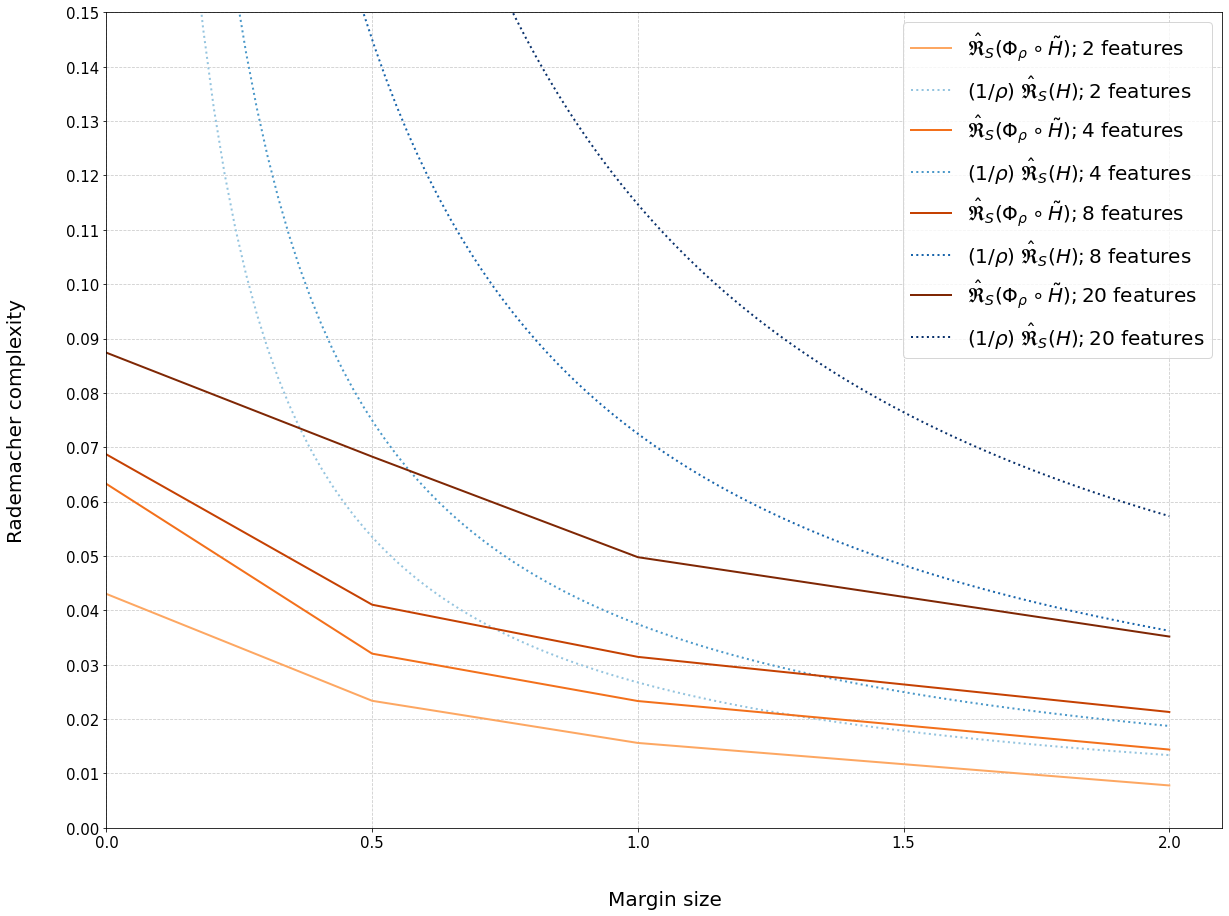

In [16]:
import matplotlib.cm as cm

folder_names = ["voice_2_500_maxiter100", "voice_4_500_maxiter100", "voice_8_500_maxiter100", "voice_20_500_maxiter100"]
labels = ['2 features', '4 features', '8 features', '20 features']

BOUNDS = np.array([1e-12]) # np.array([1e-12, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
# MARGINS = np.array([0, 0.2, 0.6, 1.0, 2.0])

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, folder_name in enumerate(folder_names):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for BOUND in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file('histories/'+folder_name+'/margin_loss_b' + str(BOUND) + '_m' + str(mar))
            com.append(calc_complexity(h))

        linear_rad = calc_complexity( load_file('histories/'+folder_name+'/confidence_b' + str(BOUND)) )
        print(linear_rad)

        plt.plot(MARGINS, com, c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}); $'+labels[index])
        sp = np.linspace(0,2,100)
        yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        yy = np.insert(yy,0,None)
        plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H);$'+labels[index], ls=':')



plt.ylim(0,0.15)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\hat{\mathfrak{R}}_{S}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMFEAT.png", bbox_inches='tight')

plt.show()


0.026745058302394938
0.037459757743982705
0.07247954506588514
0.11467582671258673


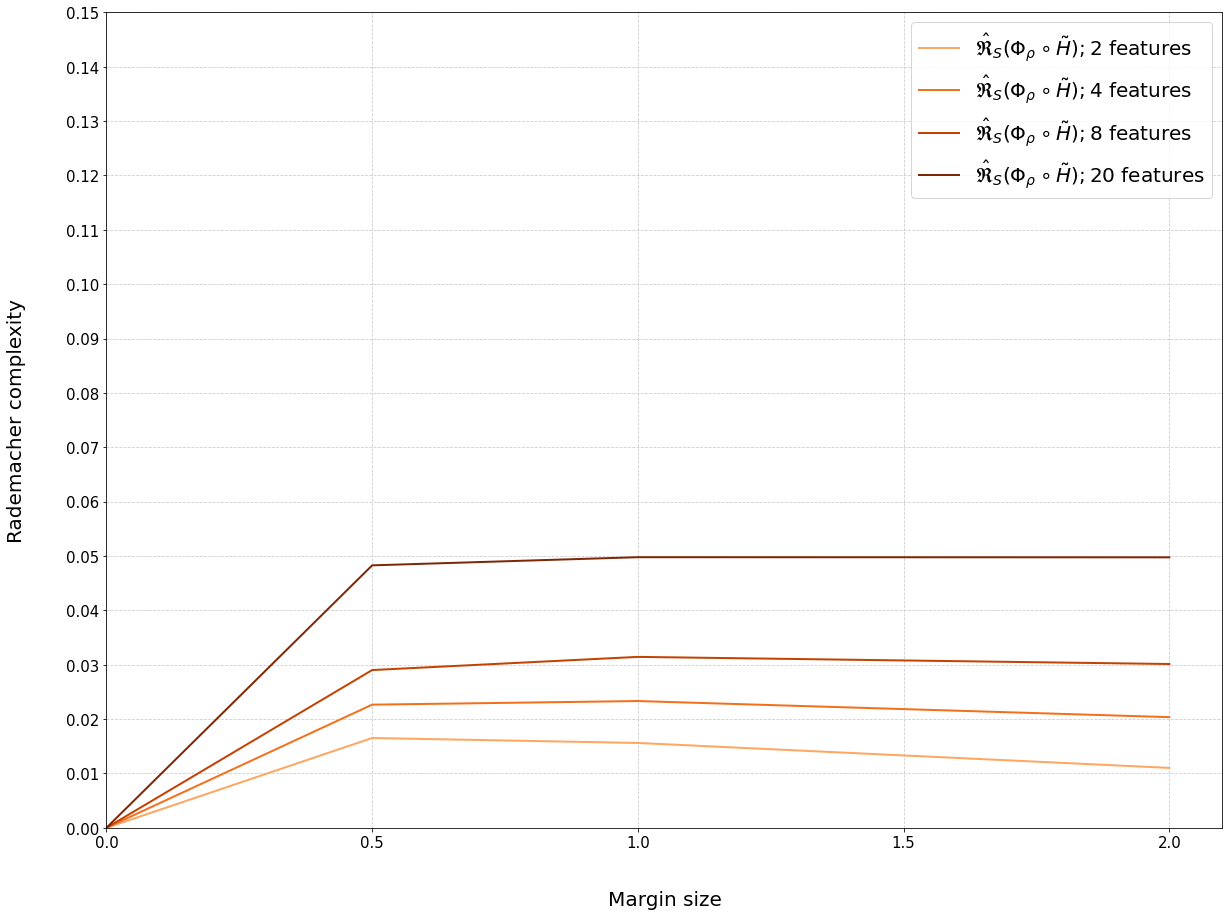

In [6]:
import matplotlib.cm as cm

folder_names = ["voice_2_500_maxiter100", "voice_4_500_maxiter100", "voice_8_500_maxiter100", "voice_20_500_maxiter100"]
labels = ['2 features', '4 features', '8 features', '20 features']

BOUNDS = np.array([1e-12]) # np.array([1e-12, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
# MARGINS = np.array([0, 0.2, 0.6, 1.0, 2.0])

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, folder_name in enumerate(folder_names):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for BOUND in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file('histories/'+folder_name+'/margin_loss_b' + str(BOUND) + '_m' + str(mar))
            com.append(calc_complexity(h))

        linear_rad = calc_complexity( load_file('histories/'+folder_name+'/confidence_b' + str(BOUND)) )
        print(linear_rad)

        plt.plot(MARGINS, com * np.sqrt(MARGINS), c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}); $'+labels[index])
        #sp = np.linspace(0,2,100)
        #y = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        #yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H);$'+labels[index], ls=':')



plt.ylim(0,0.15)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\hat{\mathfrak{R}}_{S}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMFEAT-e1.png", bbox_inches='tight')

plt.show()


0.026745058302394938
0.037459757743982705
0.07247954506588514
0.11467582671258673


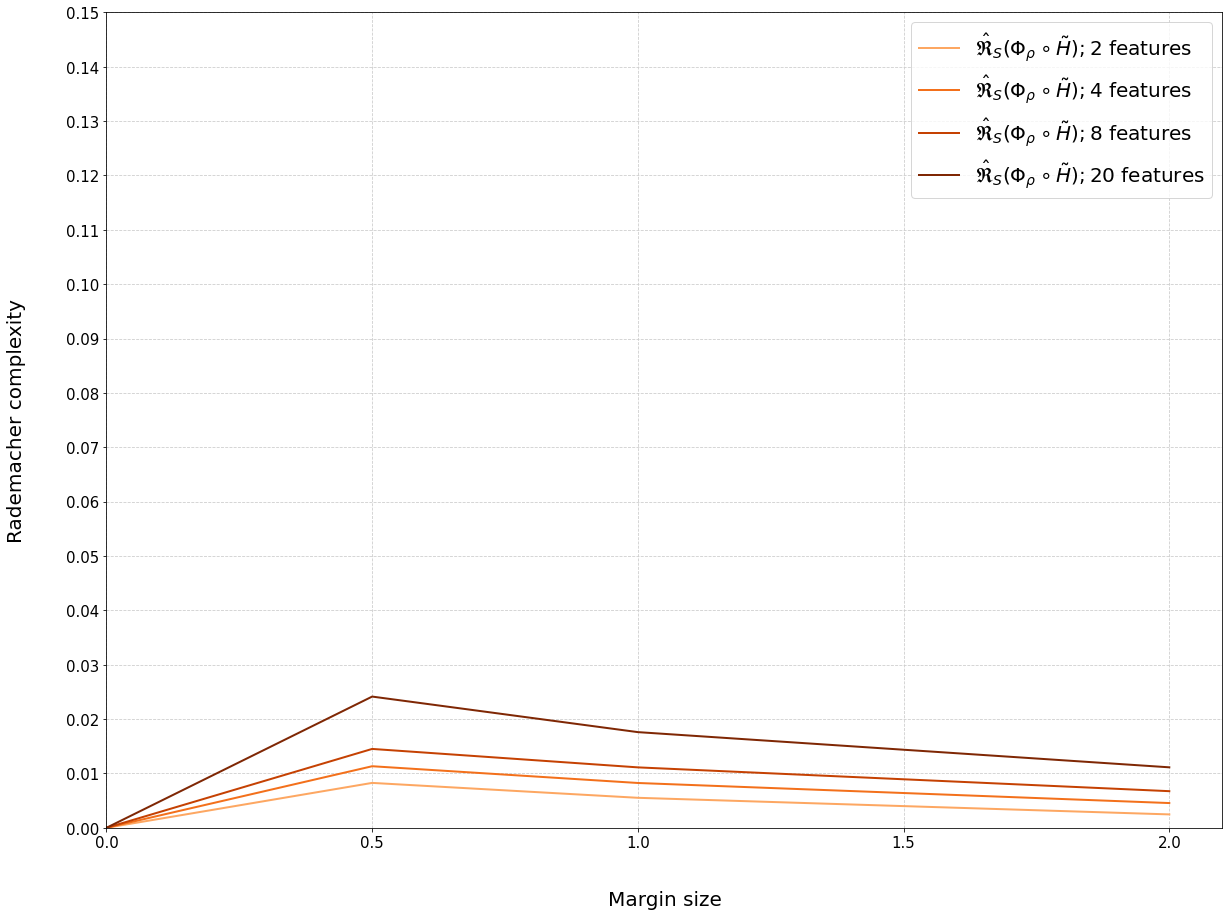

In [18]:
import matplotlib.cm as cm

folder_names = ["voice_2_500_maxiter100", "voice_4_500_maxiter100", "voice_8_500_maxiter100", "voice_20_500_maxiter100"]
labels = ['2 features', '4 features', '8 features', '20 features']

fex = [2,4,8,20]

BOUNDS = np.array([1e-12]) # np.array([1e-12, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
# MARGINS = np.array([0, 0.2, 0.6, 1.0, 2.0])

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, folder_name in enumerate(folder_names):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for BOUND in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file('histories/'+folder_name+'/margin_loss_b' + str(BOUND) + '_m' + str(mar))
            com.append(calc_complexity(h))

        linear_rad = calc_complexity( load_file('histories/'+folder_name+'/confidence_b' + str(BOUND)) )
        print(linear_rad)

        plt.plot(MARGINS, com * np.sqrt(MARGINS) / np.sqrt(np.array(fex)), c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}); $'+labels[index])
        #sp = np.linspace(0,2,100)
        #y = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        #yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H);$'+labels[index], ls=':')



plt.ylim(0,0.15)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\hat{\mathfrak{R}}_{S}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMFEAT-e2.png", bbox_inches='tight')

plt.show()


### graph 2

FileNotFoundError: [Errno 2] No such file or directory: 'histories/voice_full_500_maxiter100/margin_loss_b1e-12_m0.0'

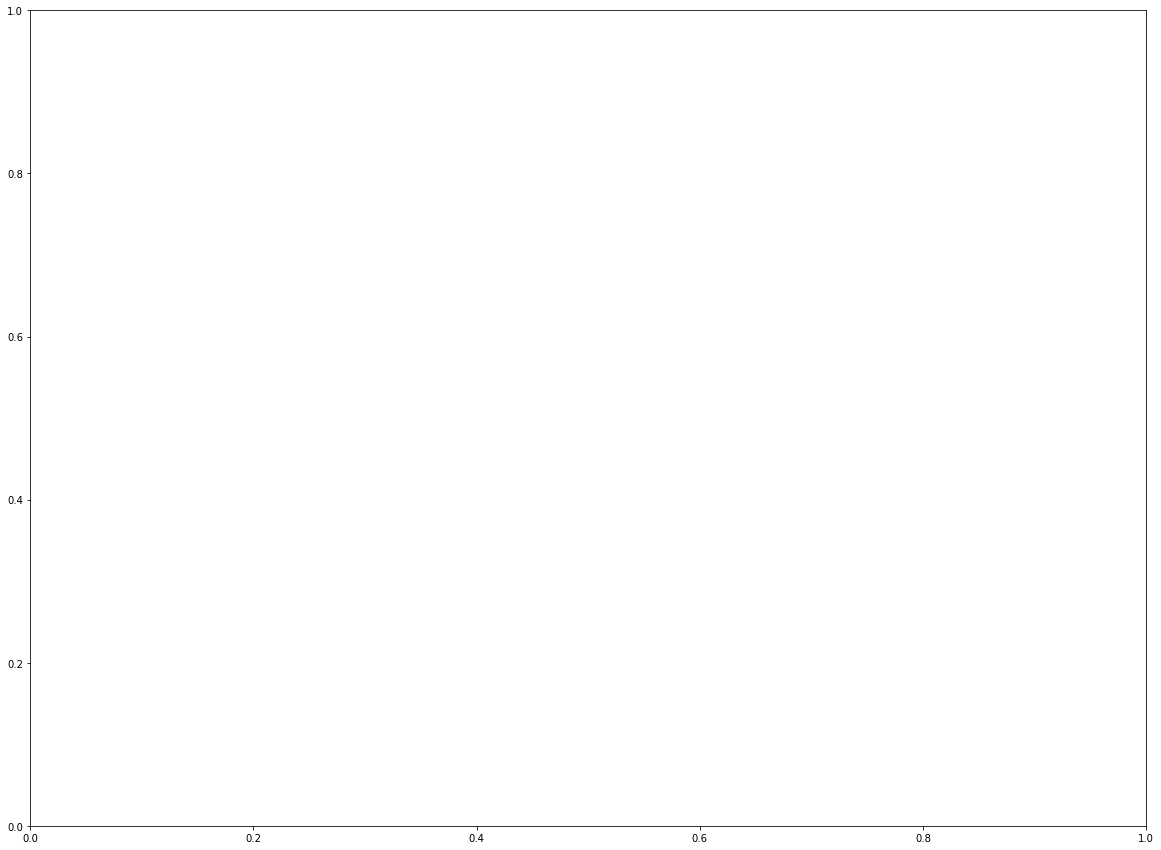

In [13]:
import matplotlib.cm as cm

folder_names = ["voice_2_500_maxiter100", "voice_4_500_maxiter100", "voice_8_500_maxiter100", "voice_full_500_maxiter100"]
labels = ['2 features', '4 features', '8 features', '20 features']

BOUNDS = np.array([1e-12]) # np.array([1e-12, 0.5, 1.0])
MARGINS = np.array([0, 0.5, 1.0, 2.0])
# MARGINS = np.array([0, 0.2, 0.6, 1.0, 2.0])

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.1


feats = [2,4,8,20]

for BOUND in BOUNDS:
    for mar in MARGINS:
        color_val += 0.25
        cmain = cm.Reds(color_val)        
        com = []
        for fe in feats:
            if (fe == 20): fe = 'full'
            folder_name = 'voice_'+str(fe)+'_500_maxiter100'
            h = load_file('histories/'+folder_name+'/margin_loss_b' + str(BOUND) + '_m' + str(mar))
            com.append(calc_complexity(h))
        
        plt.plot(feats, com, c=cmain, lw=3, label=r'margin = $'+str(mar)+'$')


plt.ylim(0,0.12)
#plt.xlim(-0.5,2.5)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

#plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.xlabel("Number of features", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ dependance on number of features', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMFEAT2.png", bbox_inches='tight')

plt.show()
